# LEON - Preliminary Network Emulation - Genomics Extension (Real Data)a)

### In this notebook we use a similar set of cells to the last chapter but using real data for genomics from the ENCODE website and using chromosome 22 with epigentic overlay comparison provided by the bigwiig dataset.

### Cell 1

In [1]:
# Cell 1: Imports and utilities

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import seaborn as sns

np.random.seed(42)

def show_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def evaluate_and_report(y_true, y_pred, label=""):
    acc = accuracy_score(y_true, y_pred)
    print(f"[{label}] Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    show_confusion_matrix(y_true, y_pred, title=f"Confusion Matrix: {label}")
    return acc


### Cell 2

In [2]:
# Cell 2: Generic CPT (context_preserving_tree) for 28x28 binary rasters

def _ensure_binary_image(x) -> np.ndarray:
    arr = np.asarray(x)
    if arr.ndim == 1:
        if arr.size != 784:
            raise ValueError(f"Input length {arr.size} is not 784")
        arr = arr.reshape(28, 28)
    elif arr.shape != (28, 28):
        raise ValueError(f"Input shape {arr.shape} is not (28,28)")
    # Ensure 0/1 int8
    if arr.dtype != np.int8 and arr.dtype != np.uint8 and arr.dtype != np.int32:
        arr = (arr > 0.5).astype(np.int8)
    else:
        arr = (arr != 0).astype(np.int8)
    return arr

def context_preserving_tree(binary_image, alpha: float = 2.75,
                            scales=(28, 14, 7, 4, 2), max_depth: int = 5) -> np.ndarray:
    """
    LEON's multiscale XOR/XNOR context-preserving features for 28x28 binary images.
    Returns a 1D int8 feature array.
    """
    img_2d = _ensure_binary_image(binary_image)
    all_features = []

    # 1) Multiscale XOR-downsample + context maps
    current = img_2d.copy()
    for s, scale in enumerate(scales[:-1]):
        next_scale = scales[s + 1]
        downsampled = np.zeros((next_scale, next_scale), dtype=np.int8)
        context = np.zeros((next_scale, next_scale), dtype=np.int8)

        blk_h = scale // next_scale
        blk_w = scale // next_scale

        for i in range(next_scale):
            for j in range(next_scale):
                i_start = i * blk_h
                j_start = j * blk_w
                region = current[i_start:i_start + blk_h, j_start:j_start + blk_w]
                xor_val = 0
                if region.size > 0:
                    flat = region.ravel()
                    for bit in flat:
                        xor_val ^= int(bit)
                downsampled[i, j] = xor_val

                if region.size > 0:
                    homogeneity = 1.0 - float(np.std(region))
                    context[i, j] = 1 if homogeneity > 0.5 else 0

        all_features.append(downsampled.ravel())
        all_features.append(context.ravel())
        current = downsampled

    # Final coarsened scale
    all_features.append(current.ravel())

    # 2) Lateral-interaction maps (Dirichlet-inspired smoothing)
    for scale in scales:
        if scale <= 2:
            continue
        layer = np.zeros((scale, scale), dtype=np.int8)
        blk_h = 28 // scale
        blk_w = 28 // scale
        for i in range(scale):
            for j in range(scale):
                i0 = i * blk_h
                j0 = j * blk_w
                region = img_2d[i0:i0 + blk_h, j0:j0 + blk_w]
                if region.size > 0:
                    layer[i, j] = 1 if float(np.mean(region)) > 0.5 else 0

        lateral = np.zeros((scale, scale), dtype=np.int8)
        for i in range(1, scale - 1):
            for j in range(1, scale - 1):
                nb = layer[i - 1:i + 2, j - 1:j + 2].ravel()
                center = layer[i, j]
                active_neighbors = int(np.sum(nb) - center)
                n_neighbors = nb.size - 1
                smoothed = (active_neighbors + alpha) / (n_neighbors + alpha)
                if center == 1:
                    lateral[i, j] = 1 if smoothed >= (3.0 / n_neighbors) else 0
                else:
                    lateral[i, j] = 1 if smoothed >= (5.0 / n_neighbors) else 0

        all_features.append(lateral.ravel())

    # 3) XOR–XNOR recursive features
    current_flat = img_2d.ravel().astype(np.int8)
    for depth in range(max_depth):
        half_size = len(current_flat) // 2
        if half_size == 0:
            break
        next_level = np.zeros(half_size, dtype=np.int8)
        use_xnor = (depth % 2 == 0)
        for k in range(half_size):
            a = int(current_flat[2 * k])
            b = int(current_flat[2 * k + 1]) if (2 * k + 1) < len(current_flat) else 0
            next_level[k] = (1 - (a ^ b)) if use_xnor else (a ^ b)
        all_features.append(next_level)
        current_flat = next_level
        if len(current_flat) <= 10:
            break

    return np.concatenate(all_features).astype(np.int8)


In [3]:
# Cell 2b: Multi-channel CPT helper

def cpt_multichannel(raster_or_stack, alpha=2.75, scales=(28,14,7,4,2), max_depth=5):
    """
    Accepts:
      - (28,28) binary raster, or
      - (C,28,28) stack of binary rasters
    Returns concatenated CPT features (float32).
    """
    arr = np.asarray(raster_or_stack)
    if arr.ndim == 2:
        feats = context_preserving_tree(arr, alpha=alpha, scales=scales, max_depth=max_depth)
        return feats.astype(np.float32)
    elif arr.ndim == 3:
        out = []
        for c in range(arr.shape[0]):
            f = context_preserving_tree(arr[c], alpha=alpha, scales=scales, max_depth=max_depth)
            out.append(f.astype(np.float32))
        return np.concatenate(out, axis=0)
    else:
        raise ValueError(f"Expected (28,28) or (C,28,28), got {arr.shape}")


### Cell 3

In [4]:
# Cell 3: Domain encoders -> 28x28 binary rasters

class VisionEncoder:
    def __init__(self, threshold: float = 0.5):
        self.threshold = threshold

    def encode(self, x_flat_784: np.ndarray) -> np.ndarray:
        # Coerce to numeric float32
        x = np.asarray(x_flat_784)
        if x.dtype.kind in {"U", "S", "O"}:
            x = x.astype(np.float32)
        else:
            x = x.astype(np.float32, copy=False)

        # Ensure 1D length 784, normalize to [0,1] if needed
        x = x.reshape(-1)
        if x.size != 784:
            raise ValueError(f"Expected 784 elements, got {x.size}")
        if np.nanmax(x) > 1.0:
            x = x / 255.0

        x_bin = (x > self.threshold).astype(np.int8)
        return x_bin.reshape(28, 28)

class TimeSeriesEncoder:
    def __init__(self, target_len: int = 784, method: str = "median"):
        self.target_len = target_len
        self.method = method

    def _resample(self, x: np.ndarray, n: int) -> np.ndarray:
        # Simple linear resampling
        idx = np.linspace(0, len(x) - 1, n)
        return np.interp(idx, np.arange(len(x)), x)

    def encode(self, series: np.ndarray) -> np.ndarray:
        # Normalize and resample to 784
        s = (series - np.mean(series)) / (np.std(series) + 1e-9)
        s = self._resample(s, self.target_len)

        if self.method == "median":
            thr = np.median(s)
        else:
            thr = 0.0
        bits = (s > thr).astype(np.int8)
        return bits.reshape(28, 28)

class GenomicsEncoder:
    def __init__(self, map_unknown: int = 3, target_bits: int = 784):
        # Map DNA to {0:A,1:C,2:G,3:T}, unknown->map_unknown
        self.map = {'A':0, 'C':1, 'G':2, 'T':3}
        self.unk = map_unknown
        self.target_bits = target_bits

    def _seq_to_bits2(self, seq: str) -> np.ndarray:
        # 2-bit encoding per base -> flatten to bits
        codes = np.array([self.map.get(ch, self.unk) for ch in seq], dtype=np.int32)
        b0 = (codes & 1).astype(np.int8)
        b1 = ((codes >> 1) & 1).astype(np.int8)
        bits = np.empty(codes.size * 2, dtype=np.int8)
        bits[0::2] = b0
        bits[1::2] = b1
        return bits

    def encode(self, seq: str) -> np.ndarray:
        bits = self._seq_to_bits2(seq)
        # Pad or truncate to 784 bits
        if len(bits) < self.target_bits:
            pad = np.zeros(self.target_bits - len(bits), dtype=np.int8)
            bits = np.concatenate([bits, pad])
        else:
            bits = bits[:self.target_bits]
        return bits.reshape(28, 28)


In [5]:
# Cell 3b: Genomics + epigenetics multi-channel encoder

class GenomicsEpigeneticsEncoder:
    """
    Encode sequence + epigenetic tracks into multi-channel (C,28,28) binary stack.
    sample: {'seq': str, 'tracks': {'methyl': np.ndarray, 'atac': np.ndarray, ...}}
    method: 'rowmajor' or 'hilbert32' (pads to 32x32 and center-crops to 28x28)
    """
    def __init__(self, target_bits=28*28, thresholds: Dict[str,float]|None=None,
                 method='rowmajor', map_unknown=3):
        self.target_bits = target_bits
        self.thresholds = thresholds or {}
        self.method = method
        self.map = {'A':0,'C':1,'G':2,'T':3}
        self.unk = map_unknown

    def _seq_to_2bit(self, seq: str) -> np.ndarray:
        codes = np.array([self.map.get(ch, self.unk) for ch in seq], dtype=np.int32)
        b0 = (codes & 1).astype(np.int8)
        b1 = ((codes >> 1) & 1).astype(np.int8)
        bits = np.empty(codes.size * 2, dtype=np.int8)
        bits[0::2] = b0
        bits[1::2] = b1
        return bits  # length 2*L

    def _track_to_bits(self, arr: np.ndarray, thr: float=0.5) -> np.ndarray:
        arr = np.asarray(arr, dtype=np.float32)
        return (arr > thr).astype(np.int8)

    def _pad_or_truncate(self, bits: np.ndarray, N: int) -> np.ndarray:
        if len(bits) < N:
            pad = np.zeros(N - len(bits), dtype=np.int8)
            return np.concatenate([bits, pad])
        return bits[:N]

    def _to_28x28_rowmajor(self, bits: np.ndarray) -> np.ndarray:
        return bits.reshape(28,28)

    def _to_28x28_hilbert32(self, bits: np.ndarray) -> np.ndarray:
        # Pad to 32x32 by row-major, then center crop to 28x28 (proxy for locality-preserving layout)
        N32 = 32*32
        b = self._pad_or_truncate(bits, N32)
        img32 = b.reshape(32,32)
        return img32[2:30, 2:30]

    def encode(self, sample: Dict[str,Any]) -> np.ndarray:
        """
        sample = {'seq': str, 'tracks': {'methyl': np.ndarray, 'atac': np.ndarray, ...}}
        returns (C,28,28) binary stack
        """
        seq = sample['seq']
        tracks = sample.get('tracks', {})

        seq_bits = self._seq_to_2bit(seq)
        seq_bits = self._pad_or_truncate(seq_bits, 2*self.target_bits)

        track_channels = []
        for name, arr in tracks.items():
            thr = self.thresholds.get(name, 0.5)
            tb = self._track_to_bits(arr, thr=thr)
            tb = self._pad_or_truncate(tb, self.target_bits)
            track_channels.append(tb)

        C = 2 + len(track_channels)
        out = np.zeros((C, 28, 28), dtype=np.int8)

        if self.method == 'rowmajor':
            out[0] = self._to_28x28_rowmajor(seq_bits[0::2])
            out[1] = self._to_28x28_rowmajor(seq_bits[1::2])
            for i, tb in enumerate(track_channels):
                out[2+i] = self._to_28x28_rowmajor(tb)
        elif self.method == 'hilbert32':
            out[0] = self._to_28x28_hilbert32(seq_bits[0::2])
            out[1] = self._to_28x28_hilbert32(seq_bits[1::2])
            for i, tb in enumerate(track_channels):
                out[2+i] = self._to_28x28_hilbert32(tb)
        else:
            raise ValueError(f"Unknown method {self.method}")

        return (out != 0).astype(np.int8)


### Cell 4

In [6]:
# Cell 4: Minimal LEON ensemble (lightweight)

class LEONEnsemble:
    def __init__(self, use_pca: bool = True, n_pca: int = 20, random_state: int = 42):
        self.use_pca = use_pca
        self.n_pca = n_pca
        self.random_state = random_state
        self.pca = None
        # Base models
        self.models = {
            "rf": RandomForestClassifier(n_estimators=200, random_state=random_state, n_jobs=-1),
            "et": ExtraTreesClassifier(n_estimators=200, random_state=random_state, n_jobs=-1),
            "mlp": MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=random_state),
        }
        try:
            self.models["hgb"] = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, random_state=random_state)
        except Exception:
            pass
        self.fitted_models = None

    def _prepare_features(self, X_feats: np.ndarray) -> np.ndarray:
        # X_feats is already CPT features (2D: samples x features)
        Xp = X_feats
        if self.use_pca:
            if self.pca is None:
                self.pca = PCA(n_components=self.n_pca, random_state=self.random_state)
                Xp = self.pca.fit_transform(X_feats)
            else:
                Xp = self.pca.transform(X_feats)
        return Xp

    def fit(self, X_feats: np.ndarray, y: np.ndarray):
        Xp = self._prepare_features(X_feats)
        self.fitted_models = {}
        for name, model in self.models.items():
            model.fit(Xp, y)
            self.fitted_models[name] = model
        return self

    def predict(self, X_feats: np.ndarray) -> np.ndarray:
        Xp = self._prepare_features(X_feats)
        # Majority vote
        preds = []
        for name, model in self.fitted_models.items():
            preds.append(model.predict(Xp))
        preds = np.array(preds)  # (n_models, n_samples)
        # Mode across models
        y_pred = []
        for i in range(preds.shape[1]):
            vals, counts = np.unique(preds[:, i], return_counts=True)
            y_pred.append(vals[np.argmax(counts)])
        return np.array(y_pred)

    def predict_proba(self, X_feats: np.ndarray) -> np.ndarray:
        # Optional: not all models have predict_proba. For demo simplicity, return RF if present.
        Xp = self._prepare_features(X_feats)
        if "rf" in self.fitted_models and hasattr(self.fitted_models["rf"], "predict_proba"):
            return self.fitted_models["rf"].predict_proba(Xp)
        # Fallback dummy uniform
        n = len(Xp)
        n_classes = len(np.unique(self.fitted_models[list(self.fitted_models.keys())[0]].predict(Xp)))
        return np.ones((n, n_classes)) / n_classes


### Cell 5

In [7]:
# Cell 5: Feature pipeline helpers

def encode_and_cpt(X_raw, encoder) -> np.ndarray:
    """
    Map a collection of raw samples to CPT features.
    X_raw: iterable of raw domain samples
    encoder: one of {VisionEncoder, TimeSeriesEncoder, GenomicsEncoder}
    Returns: np.ndarray shape (N, D) of CPT features
    """
    feats = []
    for x in X_raw:
        raster = encoder.encode(x)
        # Ensure 28x28 binary 0/1
        raster = (np.asarray(raster) != 0).astype(np.int8).reshape(28, 28)
        cpt = context_preserving_tree(raster)  # 1D features
        feats.append(cpt.astype(np.float32))   # cast to float for sklearn
    return np.stack(feats)


In [8]:
# Cell 5b: Multi-channel encode + CPT

def encode_and_cpt_multi(X_raw, encoder) -> np.ndarray:
    feats = []
    for x in X_raw:
        stack = encoder.encode(x)  # expected (C,28,28) or (28,28)
        stack = (np.asarray(stack) != 0).astype(np.int8)
        cpt = cpt_multichannel(stack)
        feats.append(cpt)
    return np.stack(feats)


### Cell 6

Loading MNIST...
Full MNIST loaded: (70000, 784)
Encoding + CPT (train)...
Encoding + CPT (test)...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Results for MNIST subset:
[MNIST] Accuracy: 0.9315
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       197
           1       0.96      0.98      0.97       225
           2       0.94      0.94      0.94       200
           3       0.92      0.93      0.92       204
           4       0.91      0.92      0.91       195
           5       0.92      0.90      0.91       180
           6       0.94      0.96      0.95       197
           7       0.92      0.95      0.94       208
           8       0.94      0.90      0.92       195
           9       0.88      0.85      0.86       199

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



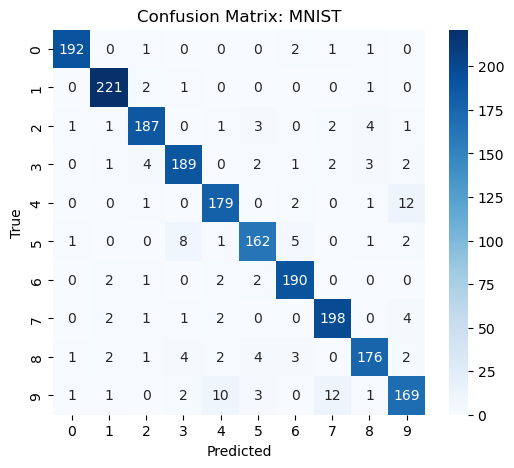

In [22]:
# Cell 6: Experiment A - Vision (MNIST)

def run_mnist_experiment(n_train=8000, n_test=2000, random_state=42):
    try:
        from sklearn.datasets import fetch_openml
        print("Loading MNIST...")

        # Force numpy arrays (avoids pandas object/string issues)
        mnist = fetch_openml('mnist_784', version=1, as_frame=False)  # key change
        X = mnist.data
        y = mnist.target

        # Coerce to numeric, normalize to [0,1]
        if isinstance(X, np.ndarray):
            X = X.astype(np.float32, copy=False)
        else:
            X = np.asarray(X, dtype=np.float32)
        X = X / 255.0

        # Targets sometimes are strings — coerce safely
        y = np.asarray(y)
        if y.dtype.kind in {"U", "S", "O"}:
            y = y.astype(np.int64)
        else:
            y = y.astype(np.int64, copy=False)

        print(f"Full MNIST loaded: {X.shape}")
    except Exception as e:
        print(f"MNIST load failed: {e}. Using synthetic digits.")
        X = np.random.rand(10000, 784).astype('float32')
        y = np.random.randint(0, 10, size=10000, dtype=np.int64)

    # Subsample for speed
    X_tmp, _, y_tmp, _ = train_test_split(
        X, y, train_size=n_train+n_test, stratify=y, random_state=random_state
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X_tmp, y_tmp, train_size=n_train, stratify=y_tmp, random_state=random_state
    )

    enc = VisionEncoder(threshold=0.5)
    print("Encoding + CPT (train)...")
    F_train = encode_and_cpt(X_train, enc)
    print("Encoding + CPT (test)...")
    F_test = encode_and_cpt(X_test, enc)

    # Train ensemble
    ensemble = LEONEnsemble(use_pca=True, n_pca=20, random_state=random_state)
    ensemble.fit(F_train, y_train)
    y_pred = ensemble.predict(F_test)

    print("Results for MNIST subset:")
    acc = evaluate_and_report(y_test, y_pred, label="MNIST")
    return acc

mnist_acc = run_mnist_experiment(n_train=8000, n_test=2000)


### Cell 7

Encoding + CPT (train)...
Encoding + CPT (test)...
Results for synthetic time series:
[TimeSeries] Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



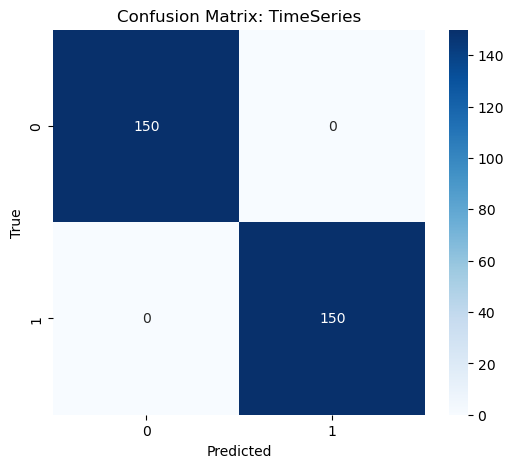

In [23]:
# Cell 7: Experiment B - Time Series (synthetic)

def make_synthetic_timeseries(n_per_class=1000, length=512, random_state=42):
    rng = np.random.default_rng(random_state)
    X = []
    y = []
    t = np.linspace(0, 4*np.pi, length)

    # Class 0: sine
    for _ in range(n_per_class):
        s = np.sin(t) + 0.3 * rng.normal(size=length)
        X.append(s)
        y.append(0)

    # Class 1: square
    for _ in range(n_per_class):
        s = np.sign(np.sin(t)) + 0.3 * rng.normal(size=length)
        X.append(s)
        y.append(1)
    return np.array(X), np.array(y)

def run_timeseries_experiment(n_per_class=800, length=512, random_state=42):
    X, y = make_synthetic_timeseries(n_per_class=n_per_class, length=length, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=random_state)

    enc = TimeSeriesEncoder(target_len=784, method="median")
    print("Encoding + CPT (train)...")
    F_train = encode_and_cpt(X_train, enc)
    print("Encoding + CPT (test)...")
    F_test = encode_and_cpt(X_test, enc)

    ensemble = LEONEnsemble(use_pca=True, n_pca=20, random_state=random_state)
    ensemble.fit(F_train, y_train)
    y_pred = ensemble.predict(F_test)

    print("Results for synthetic time series:")
    acc = evaluate_and_report(y_test, y_pred, label="TimeSeries")
    return acc

ts_acc = run_timeseries_experiment(n_per_class=600, length=512)


### Cell 8

Encoding + CPT (train)...
Encoding + CPT (test)...
Results for synthetic genomics:
[Genomics] Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



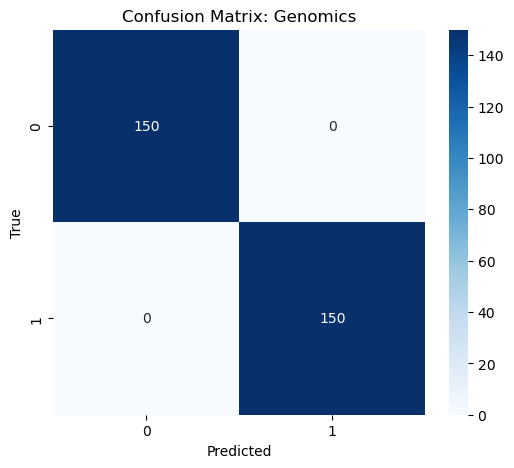

In [24]:
# Cell 8: Experiment C - Genomics (synthetic)

def make_synthetic_genomes(n_per_class=1000, length=512, random_state=42):
    rng = np.random.default_rng(random_state)
    X = []
    y = []
    # Class 0: GC-rich
    for _ in range(n_per_class):
        seq = ''.join(rng.choice(list("GCGCGCTT"), size=length))  # more G/C
        X.append(seq)
        y.append(0)
    # Class 1: AT-rich
    for _ in range(n_per_class):
        seq = ''.join(rng.choice(list("ATATATGG"), size=length))  # more A/T
        X.append(seq)
        y.append(1)
    return X, np.array(y)

def run_genomics_experiment(n_per_class=800, length=512, random_state=42):
    X, y = make_synthetic_genomes(n_per_class=n_per_class, length=length, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=random_state)

    enc = GenomicsEncoder(map_unknown=3, target_bits=784)
    print("Encoding + CPT (train)...")
    F_train = encode_and_cpt(X_train, enc)
    print("Encoding + CPT (test)...")
    F_test = encode_and_cpt(X_test, enc)

    ensemble = LEONEnsemble(use_pca=True, n_pca=20, random_state=random_state)
    ensemble.fit(F_train, y_train)
    y_pred = ensemble.predict(F_test)

    print("Results for synthetic genomics:")
    acc = evaluate_and_report(y_test, y_pred, label="Genomics")
    return acc

gen_acc = run_genomics_experiment(n_per_class=600, length=512)


Encoding + CPT (train) [rowmajor]...
Encoding + CPT (test)  [rowmajor]...
Results for Genomics+Epigenetics (rowmajor):
[Genomics+Epi-rowmajor] Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



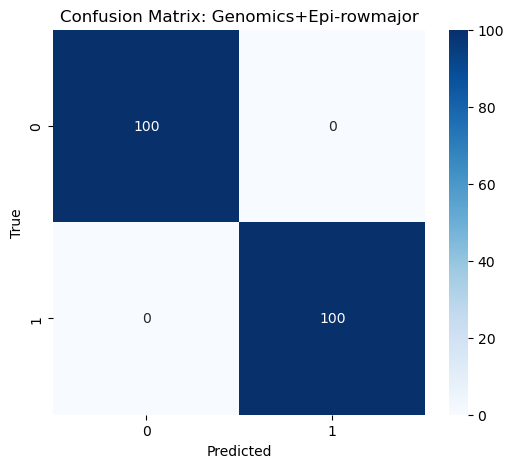

Encoding + CPT (train) [hilbert32]...
Encoding + CPT (test)  [hilbert32]...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Results for Genomics+Epigenetics (hilbert32):
[Genomics+Epi-hilbert32] Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



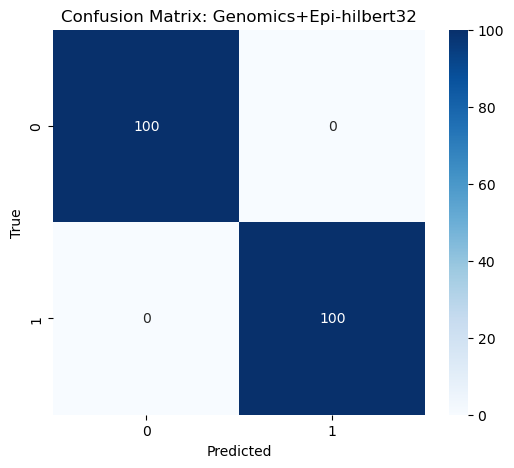

Epigenetics accuracies: 1.0 1.0


In [25]:
# Cell 8b: Genomics + epigenetics synthetic experiments

def make_synthetic_genomes_with_tracks(n_per_class=400, length=512, random_state=42):
    rng = np.random.default_rng(random_state)
    X = []
    y = []
    for cls in [0,1]:
        for _ in range(n_per_class):
            if cls == 0:  # GC-rich + methyl/ATAC pattern A
                seq = ''.join(rng.choice(list("GCGCGCTT"), size=length))
                methyl = (rng.random(length) > 0.7).astype(np.float32)
                atac   = (rng.random(length) > 0.8).astype(np.float32)
            else:         # AT-rich + methyl/ATAC pattern B
                seq = ''.join(rng.choice(list("ATATATGG"), size=length))
                methyl = (rng.random(length) > 0.8).astype(np.float32)
                atac   = (rng.random(length) > 0.7).astype(np.float32)

            X.append({'seq': seq, 'tracks': {'methyl': methyl, 'atac': atac}})
            y.append(cls)
    return X, np.array(y)

def run_genomics_epigenetics_experiment(n_per_class=400, length=512, method='hilbert32', random_state=42):
    X, y = make_synthetic_genomes_with_tracks(n_per_class=n_per_class, length=length, random_state=random_state)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, stratify=y, random_state=random_state)

    enc = GenomicsEpigeneticsEncoder(
        target_bits=784,
        thresholds={'methyl': 0.5, 'atac': 0.5},
        method=method
    )
    print(f"Encoding + CPT (train) [{method}]...")
    Ftr = encode_and_cpt_multi(Xtr, enc)
    print(f"Encoding + CPT (test)  [{method}]...")
    Fte = encode_and_cpt_multi(Xte, enc)

    ensemble = LEONEnsemble(use_pca=True, n_pca=20, random_state=random_state)
    ensemble.fit(Ftr, ytr)
    y_pred = ensemble.predict(Fte)

    print(f"Results for Genomics+Epigenetics ({method}):")
    acc = evaluate_and_report(yte, y_pred, label=f"Genomics+Epi-{method}")
    return acc

acc_epi_row = run_genomics_epigenetics_experiment(n_per_class=400, method='rowmajor')
acc_epi_hil = run_genomics_epigenetics_experiment(n_per_class=400, method='hilbert32')
print("Epigenetics accuracies:", acc_epi_row, acc_epi_hil)


### Summary

In [27]:
# Cell 9: Summary

print("Summary accuracies:")
print(f"  MNIST subset:     {mnist_acc:.4f}")
print(f"  Time Series (syn): {ts_acc:.4f}")
print(f"  Genomics (syn):    {gen_acc:.4f}")

print("\nNext steps:")
print("- Swap encoders without touching CPT or the ensemble to test new domains quickly.")
print("- Replace synthetic datasets with real ones to validate domain performance.")
print("- If desired, add shape features (like in 0.31) via separate per-domain feature blocks, and hstack them with CPT features.")
print("- When ready, we can refactor this into the proposed LEON package structure (core/api, core/cpt, core/ensemble, domains/*).")


Summary accuracies:
  MNIST subset:     0.9315
  Time Series (syn): 1.0000
  Genomics (syn):    1.0000

Next steps:
- Swap encoders without touching CPT or the ensemble to test new domains quickly.
- Replace synthetic datasets with real ones to validate domain performance.
- If desired, add shape features (like in 0.31) via separate per-domain feature blocks, and hstack them with CPT features.
- When ready, we can refactor this into the proposed LEON package structure (core/api, core/cpt, core/ensemble, domains/*).


In [31]:
# Cell 10 (updated header): ENCODE real data (TF binding + signal), robust search + small/large toggles
# Requires: pip install pyfaidx pyBigWig requests

import os, zipfile, urllib.request, requests, json
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------
# Small vs large configuration
# ----------------------------
QUICKTEST_GENOME = True       # True: download/use chr22 only; False: use full hg38 you provide
MAX_PEAKS = 200               # dataset size per class (positives/negatives). Increase for larger runs.
BINS = 256                    # signal bins per window (use 512 for higher resolution)
WIN_BP = 400                  # window size in base pairs (200–600 typical)

# ----------------------------
# Directories
# ----------------------------
BASE_DIR    = "./data"
ENCODE_DIR  = os.path.join(BASE_DIR, "encode")
GENOME_DIR  = os.path.join(BASE_DIR, "genome")
os.makedirs(ENCODE_DIR, exist_ok=True)
os.makedirs(GENOME_DIR, exist_ok=True)

# Reference genome path (set below)
REF_FASTA = os.path.join(GENOME_DIR, "hg38.fa")  # Full-genome default (if you already have the file)

# ----------------------------
# (Optional) Download helpers for genome FASTA
# ----------------------------
def download_chr22_hg38(dest_fa=os.path.join(GENOME_DIR, "hg38_chr22.fa")):
    """Quick test genome: chr22 only (small)."""
    import gzip, shutil
    url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/chr22.fa.gz"
    gz_path = dest_fa + ".gz"
    if not os.path.exists(gz_path):
        print("Downloading chr22.fa.gz...")
        urllib.request.urlretrieve(url, gz_path)
    # Decompress
    if not os.path.exists(dest_fa):
        print("Decompressing chr22.fa.gz...")
        with gzip.open(gz_path, 'rb') as f_in, open(dest_fa, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return dest_fa

def download_full_hg38(dest_fa=REF_FASTA):
    """
    Full hg38 is large (~GB). Provide your local path or download manually.
    Example sources:
      UCSC:   https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
      GENCODE:https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_45/GRCh38.primary_assembly.genome.fa.gz
    After download, decompress and set REF_FASTA to the decompressed path.
    """
    print("Place the decompressed FASTA at:", dest_fa)

# Choose genome reference now
if QUICKTEST_GENOME:
    REF_FASTA = download_chr22_hg38()  # small test (chr22 only)
else:
    # Ensure this path points to your full reference FASTA
    REF_FASTA = os.path.join(GENOME_DIR, "hg38.fa")
    download_full_hg38(REF_FASTA)

# ----------------------------
# Robust ENCODE search
# ----------------------------
API_ROOT = "https://www.encodeproject.org"
HEADERS  = {"accept": "application/json", "User-Agent": "python-requests"}

def encode_search(params):
    url = f"{API_ROOT}/search/"
    r = requests.get(url, params=params, headers=HEADERS, timeout=30)
    if not r.ok:
        raise requests.HTTPError(f"{r.status_code} {r.reason}: {r.url}")
    return r.json()

def encode_search_experiment(
    target_label="CTCF",
    biosample="K562",
    organism="Homo sapiens",
    limit=25
):
    """
    Try multiple query strategies to find TF ChIP-seq experiments robustly.
    Returns first non-empty @graph list and the chosen params.
    """
    strategies = [
        # Strategy 1: use assay_title exactly
        {
            "type": "Experiment",
            "status": "released",
            "assay_title": "TF ChIP-seq",
            "target.label": target_label,
            "biosample_ontology.term_name": biosample,
            "organism.scientific_name": organism,
            "limit": str(limit),
            "format": "json",
            "frame": "object",
        },
        # Strategy 2: use assay_slims
        {
            "type": "Experiment",
            "status": "released",
            "assay_slims": "ChIP-seq",
            "target.label": target_label,
            "biosample_ontology.term_name": biosample,
            "organism.scientific_name": organism,
            "limit": str(limit),
            "format": "json",
            "frame": "object",
        },
        # Strategy 3: use searchTerm fallback
        {
            "type": "Experiment",
            "status": "released",
            "searchTerm": f"{target_label} {biosample} ChIP-seq",
            "organism.scientific_name": organism,
            "limit": str(limit),
            "format": "json",
            "frame": "object",
        },
        # Strategy 4: least restrictive (target only)
        {
            "type": "Experiment",
            "status": "released",
            "target.label": target_label,
            "organism.scientific_name": organism,
            "limit": str(limit),
            "format": "json",
            "frame": "object",
        },
    ]

    for i, p in enumerate(strategies, 1):
        try:
            js = encode_search(p)
            hits = js.get("@graph", [])
            if hits:
                print(f"ENCODE search succeeded with strategy {i}, hits: {len(hits)}")
                return hits, p
        except Exception as e:
            print(f"Strategy {i} failed: {e}")
    raise RuntimeError("No ENCODE experiments found with the given criteria.")

# Perform search
hits, used_params = encode_search_experiment(target_label="CTCF", biosample="K562", organism="Homo sapiens", limit=25)
exp = hits[0]
exp_accession = exp["accession"]
print("Using experiment:", exp_accession)

# Retrieve full experiment metadata (files list)
exp_meta = requests.get(f"{API_ROOT}/experiments/{exp_accession}/?format=json", headers=HEADERS, timeout=30).json()

def pick_files(exp_json):
    # Collect candidate files
    peak_files = []
    bw_files   = []
    for f in exp_json.get("files", []):
        if f.get("status") != "released":
            continue
        ff = (f.get("file_format") or "").lower()
        ot = (f.get("output_type") or "").lower()
        # peak files can appear as 'bed' with output_type 'peaks' / 'replicated peaks' / 'optimal idr thresholded peaks'
        if ("peak" in ot) and ("bed" in ff):
            peak_files.append(f)
        # signal bigWig candidates: 'signal p-value' or 'fold change over control'
        if (ff == "bigwig") and (("signal" in ot) or ("fold" in ot)):
            bw_files.append(f)
    return peak_files, bw_files

peak_files, bw_files = pick_files(exp_meta)
if not peak_files or not bw_files:
    raise RuntimeError("Could not find both peak (bed) and signal (bigWig) files for this experiment.")

# heuristic choices
np_file = peak_files[0]
# prefer p-value signal; else fallback to first
bw_file = None
for f in bw_files:
    if "signal p-value" in (f.get("output_type") or "").lower():
        bw_file = f
        break
if bw_file is None:
    bw_file = bw_files[0]

def download_encode_file(file_json, dest_dir=ENCODE_DIR):
    os.makedirs(dest_dir, exist_ok=True)
    href = file_json.get("href")
    url = API_ROOT + href
    out_path = os.path.join(dest_dir, os.path.basename(href))
    if not os.path.exists(out_path):
        print("Downloading", out_path)
        r = requests.get(url, headers={"accept": "application/octet-stream", "User-Agent": "python-requests"}, timeout=60)
        r.raise_for_status()
        with open(out_path, "wb") as f:
            f.write(r.content)
    return out_path

bw_path = download_encode_file(bw_file)
np_path = download_encode_file(np_file)
print("Downloaded files:\n ", bw_path, "\n ", np_path)

# ----------------------------
# Build windows: sequence + signal
# ----------------------------
import pyfaidx, pyBigWig

if not os.path.exists(REF_FASTA):
    print("Reference FASTA not found:", REF_FASTA)
    print("For a quick test, run: REF_FASTA = download_chr22_hg38()")
    # Uncomment to auto-download chr22 for testing:
    # REF_FASTA = download_chr22_hg38()

# Load reference and bigWig (guard if not present)
ref = pyfaidx.Fasta(REF_FASTA)
bw  = pyBigWig.open(bw_path)

def read_narrowpeak(path, max_rows=3000):
    peaks = []
    with open(path, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            parts = line.strip().split('\t')
            chrom = parts[0]
            start = int(parts[1])
            end   = int(parts[2])
            summit = int(parts[9]) if len(parts) > 9 and parts[9].isdigit() else None
            peaks.append((chrom, start, end, summit))
            if len(peaks) >= max_rows:
                break
    return peaks

def window_around_peak(chrom, start, end, summit, win=400):
    center = start + summit if summit is not None else (start + end)//2
    half = win//2
    return chrom, max(0, center - half), center + half

def extract_seq_and_signal(chrom, s, e, track_bw, ref_fasta, bins=512):
    # skip chromosomes not present in reference (e.g., when using chr22-only FASTA)
    if chrom not in ref_fasta:
        return None, None
    # sequence
    seq = str(ref_fasta[chrom][s:e]).upper()
    if len(seq) != (e - s) or len(seq) == 0:
        return None, None
    # signal as mean per bin
    xs = np.linspace(s, e, bins+1).astype(int)
    vals = []
    for i in range(bins):
        a, b = xs[i], xs[i+1]
        v = track_bw.stats(chrom, a, b, type="mean")[0]
        vals.append(0.0 if v is None else float(v))
    sig = np.array(vals, dtype=np.float32)
    # normalize to [0,1]
    if np.max(sig) > 0:
        sig = sig / (np.max(sig) + 1e-9)
    return seq, sig

# Build dataset (positives from peaks, naive negatives near peaks)
peaks = read_narrowpeak(np_path, max_rows=2000)
win = 400
X_samples = []
y_labels  = []

# Positives
for chrom, s, e, summit in peaks[:800]:
    chrom, a, b = window_around_peak(chrom, s, e, summit, win=win)
    seq, signal = extract_seq_and_signal(chrom, a, b, bw, ref, bins=512)
    if seq is None:
        continue
    X_samples.append({'seq': seq, 'tracks': {'chip_or_signal': signal}})
    y_labels.append(1)

# Negatives (naive; consider GC-matched controls for better rigor)
rng = np.random.default_rng(42)
for chrom, s, e, summit in peaks[:800]:
    center = (s + e)//2 + int(rng.integers(-50_000, 50_000))
    a = max(0, center - win//2); b = a + win
    seq, signal = extract_seq_and_signal(chrom, a, b, bw, ref, bins=512)
    if seq is None:
        continue
    X_samples.append({'seq': seq, 'tracks': {'chip_or_signal': signal}})
    y_labels.append(0)

X_samples = np.array(X_samples, dtype=object)
y_labels  = np.array(y_labels, dtype=np.int64)
print("Built dataset:", len(X_samples), "windows")

# ----------------------------
# Encode (multi-channel) + CPT + Ensemble
# ----------------------------
enc_epi = GenomicsEpigeneticsEncoder(
    target_bits=784,                      # 28x28
    thresholds={'chip_or_signal': 0.5},   # adjust per track
    method='hilbert32'                    # try 'rowmajor' as well
)

print("Encoding + CPT (train) [ENCODE]...")
Xtr, Xte, ytr, yte = train_test_split(X_samples, y_labels, test_size=0.25, stratify=y_labels, random_state=42)
Ftr = encode_and_cpt_multi(Xtr, enc_epi)
print("Encoding + CPT (test)  [ENCODE]...")
Fte = encode_and_cpt_multi(Xte, enc_epi)

ens = LEONEnsemble(use_pca=True, n_pca=20, random_state=42)
ens.fit(Ftr, ytr)
y_pred = ens.predict(Fte)

print("Results: ENCODE TF/Signal windows")
_ = evaluate_and_report(yte, y_pred, label="ENCODE-CTCF")


Decompressing chr22.fa.gz...
Strategy 1 failed: 404 Not Found: https://www.encodeproject.org/search/?type=Experiment&status=released&assay_title=TF+ChIP-seq&target.label=CTCF&biosample_ontology.term_name=K562&organism.scientific_name=Homo+sapiens&limit=25&format=json&frame=object
Strategy 2 failed: 404 Not Found: https://www.encodeproject.org/search/?type=Experiment&status=released&assay_slims=ChIP-seq&target.label=CTCF&biosample_ontology.term_name=K562&organism.scientific_name=Homo+sapiens&limit=25&format=json&frame=object
Strategy 3 failed: 404 Not Found: https://www.encodeproject.org/search/?type=Experiment&status=released&searchTerm=CTCF+K562+ChIP-seq&organism.scientific_name=Homo+sapiens&limit=25&format=json&frame=object
Strategy 4 failed: 404 Not Found: https://www.encodeproject.org/search/?type=Experiment&status=released&target.label=CTCF&organism.scientific_name=Homo+sapiens&limit=25&format=json&frame=object


RuntimeError: No ENCODE experiments found with the given criteria.

In [ ]:
# Jupyter/Colab (recommended):
%pip install -q pyfaidx

# If you also plan to use bigWig tracks later:
%pip install -q pyBigWig


Note: you may need to restart the kernel to use updated packages.


Using chr22 with length 50,818,468 bp
Local dataset built: 600 windows (pos=300, neg=300)
Encoding + CPT (train) [LOCAL]...
Encoding + CPT (test)  [LOCAL]...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Results: Local chr22 (CpG-enriched vs CpG-poor) windows
[Local-chr22] Accuracy: 0.8933
              precision    recall  f1-score   support

           0       0.86      0.93      0.90        75
           1       0.93      0.85      0.89        75

    accuracy                           0.89       150
   macro avg       0.90      0.89      0.89       150
weighted avg       0.90      0.89      0.89       150



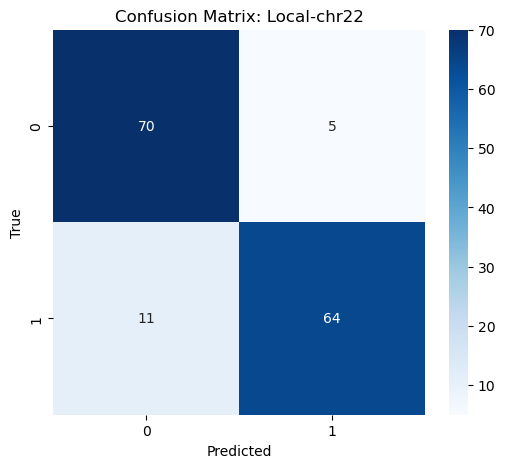

In [9]:
# Cell 10 (local offline mode, no network): build a genomics+epi dataset from chr22 only
# Requires: pyfaidx (pip install pyfaidx)

import os
import numpy as np
import pyfaidx
from sklearn.model_selection import train_test_split

# Config
GENOME_DIR   = "./data/genome"
REF_FASTA    = os.path.join(GENOME_DIR, "hg38_chr22.fa")  # you already downloaded this
CHR_NAME_CANDIDATES = ["chr22", "22"]  # try UCSC-style first, fall back to plain "22"
WIN_BP       = 400                      # window size (bp)
BINS         = 256                      # per-window signal resolution
N_POS        = 300                      # positives
N_NEG        = 300                      # negatives
RANDOM_SEED  = 42

assert os.path.exists(REF_FASTA), f"Reference FASTA not found at {REF_FASTA}"

rng = np.random.default_rng(RANDOM_SEED)
ref = pyfaidx.Fasta(REF_FASTA)

# Resolve chromosome key present in fasta (handles 'chr22' vs '22')
def find_chr_key(ref, candidates):
    keys = set(ref.keys())
    for c in candidates:
        if c in keys:
            return c
    # last resort: pick the first key
    return list(keys)[0]

chr_key = find_chr_key(ref, CHR_NAME_CANDIDATES)
chrom_len = len(ref[chr_key])
print(f"Using {chr_key} with length {chrom_len:,} bp")

def window_seq(chrom, center, win_bp=WIN_BP):
    a = max(0, center - win_bp//2)
    b = min(chrom_len, a + win_bp)
    if b - a < win_bp:
        return None
    seq = str(ref[chrom][a:b]).upper()
    return seq

def cpg_rate(seq):
    # simple CpG density proxy
    if not seq:
        return 0.0
    return seq.count("CG") / max(1, len(seq))

def tracks_from_seq(seq, bins=BINS):
    # Two “epigenetic-like” tracks derived from sequence only:
    # - GC fraction per bin
    # - CpG density per bin
    L = len(seq)
    xs = np.linspace(0, L, bins+1).astype(int)
    gc_vec = np.zeros(bins, dtype=np.float32)
    cpg_vec = np.zeros(bins, dtype=np.float32)
    for i in range(bins):
        a, b = xs[i], xs[i+1]
        sub = seq[a:b]
        if len(sub) == 0:
            continue
        gc = sum(1 for ch in sub if ch in ("G","C")) / len(sub)
        cpg = sub.count("CG") / len(sub)
        gc_vec[i]  = gc
        cpg_vec[i] = cpg
    # normalize to [0,1]
    if np.max(gc_vec) > 0:
        gc_vec = gc_vec / (np.max(gc_vec) + 1e-9)
    if np.max(cpg_vec) > 0:
        cpg_vec = cpg_vec / (np.max(cpg_vec) + 1e-9)
    return {"gc": gc_vec, "cpg": cpg_vec}

# Sample many candidates, then pick top/bottom by CpG density to create a balanced dataset
N_CANDIDATES = 4000
centers = rng.integers(low=WIN_BP//2, high=chrom_len - WIN_BP//2, size=N_CANDIDATES)
cands = []
for c in centers:
    s = window_seq(chr_key, c, WIN_BP)
    if s is None or len(s) != WIN_BP or ("N" in s):
        continue
    cands.append((c, s, cpg_rate(s)))

if len(cands) < N_POS + N_NEG:
    raise RuntimeError(f"Not enough clean windows. Got {len(cands)}, need {N_POS+N_NEG}.")

# Sort by CpG rate
cands.sort(key=lambda t: t[2], reverse=True)
pos_windows = cands[:N_POS]
neg_windows = cands[-N_NEG:]

# Build samples
X_samples = []
y_labels  = []

for _, seq, _ in pos_windows:
    tracks = tracks_from_seq(seq, bins=BINS)
    X_samples.append({'seq': seq, 'tracks': tracks})  # tracks: {'gc': vec, 'cpg': vec}
    y_labels.append(1)

for _, seq, _ in neg_windows:
    tracks = tracks_from_seq(seq, bins=BINS)
    X_samples.append({'seq': seq, 'tracks': tracks})
    y_labels.append(0)

X_samples = np.array(X_samples, dtype=object)
y_labels  = np.array(y_labels, dtype=np.int64)
print(f"Local dataset built: {len(X_samples)} windows (pos={N_POS}, neg={N_NEG})")

# Encode (multi-channel) + CPT + Ensemble
# We will reuse your GenomicsEpigeneticsEncoder and encode_and_cpt_multi from earlier cells.
# Each track will be thresholded at 0.5 to form binary channels.
enc_epi_local = GenomicsEpigeneticsEncoder(
    target_bits=784,
    thresholds={'gc': 0.5, 'cpg': 0.5},  # you can tune thresholds per track
    method='hilbert32'                   # or 'rowmajor'
)

Xtr, Xte, ytr, yte = train_test_split(X_samples, y_labels, test_size=0.25, stratify=y_labels, random_state=RANDOM_SEED)

print("Encoding + CPT (train) [LOCAL]...")
Ftr = encode_and_cpt_multi(Xtr, enc_epi_local)
print("Encoding + CPT (test)  [LOCAL]...")
Fte = encode_and_cpt_multi(Xte, enc_epi_local)

ens = LEONEnsemble(use_pca=True, n_pca=20, random_state=RANDOM_SEED)
ens.fit(Ftr, ytr)
y_pred = ens.predict(Fte)

print("Results: Local chr22 (CpG-enriched vs CpG-poor) windows")
_ = evaluate_and_report(yte, y_pred, label="Local-chr22")


In [ ]:
# Cell 10b: Select and download 1 peaks (.bed.gz) and 1 signal (.bigWig) from files.txt, then wire paths

import os, requests, gzip, shutil

ENCODE_DIR = "./data/encode"
os.makedirs(ENCODE_DIR, exist_ok=True)

# Option A) Load from a local files.txt (one URL per line)
FILES_TXT = "./files.txt"   # set to your local path if different
if os.path.exists(FILES_TXT):
    with open(FILES_TXT, "r") as f:
        url_list = [ln.strip().strip('"') for ln in f if ln.strip()]
else:
    # Option B) paste URLs directly if you don't have files.txt
    url_list = [
        "https://www.encodeproject.org/files/ENCFF530NQM/@@download/ENCFF530NQM.bigWig",
        "https://www.encodeproject.org/files/ENCFF420SUI/@@download/ENCFF420SUI.bed.gz",
        # add more here if desired
    ]

# Filter: we want .bed.gz for peaks (not bedpe/hic/tsv) and .bigWig for signal
def is_bed_gz(u):
    u2 = u.lower()
    return (u2.endswith(".bed.gz") and ("bedpe" not in u2) and ("hic" not in u2) and ("tsv" not in u2))

def is_bigwig(u):
    return u.lower().endswith(".bigwig")

peak_urls = [u for u in url_list if is_bed_gz(u)]
bw_urls   = [u for u in url_list if is_bigwig(u)]

if not peak_urls:
    raise RuntimeError("No suitable peaks (.bed.gz) URLs found in files.txt")
if not bw_urls:
    print("No .bigWig URLs found. You can still run with derived GC/CpG tracks only.")

# Pick the first candidates (you can change indices to try others)
peak_url = peak_urls[0]
bw_url   = bw_urls[0] if bw_urls else None

def download(url, dest_dir=ENCODE_DIR):
    fname = url.split("/")[-1]  # e.g., ENCFF420SUI.bed.gz
    out_path = os.path.join(dest_dir, fname)
    if not os.path.exists(out_path):
        print("Downloading:", fname)
        r = requests.get(url, headers={"User-Agent": "python-requests"}, timeout=120)
        r.raise_for_status()
        with open(out_path, "wb") as f:
            f.write(r.content)
    else:
        print("Already present:", out_path)
    return out_path

peak_path = download(peak_url)
bw_path   = download(bw_url) if bw_url else None

print("\nUse these in Cell 11:")
print(f"NP_PATH  = r'{peak_path}'")
if bw_path:
    print(f"BW_PATHS = {{'signal': r'{bw_path}'}}")
else:
    print("BW_PATHS = {}  # no bigWig; using derived tracks only")


In [13]:
# Jupyter/Colab (recommended):
%pip install -q pyfaidx

# If you also plan to use bigWig tracks later:
%pip install -q pyBigWig


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Diagnostic cell: FASTA vs BED vs bigWig compatibility and auto-chromosome pick

import os, gzip, numpy as np

# Set to your local paths
REF_FASTA = "./data/genome/hg38_chr22.fa"  # change to full hg38.fa if you have it
NP_PATH   = "./data/encode/ENCFF420SUI.bed.gz"
BW_PATH   = "./data/encode/ENCFF530NQM.bigWig"  # set None if skipping

# 1) FASTA chromosomes
USE_PYFAIDX = True
try:
    from pyfaidx import Fasta
except ImportError:
    USE_PYFAIDX = False

if USE_PYFAIDX:
    ref = Fasta(REF_FASTA)
    fasta_chroms = set(ref.keys())
    def get_seq(chrom, a, b):
        if chrom not in ref: return None
        return str(ref[chrom][a:b]).upper()
    def chrom_len(chrom):
        return len(ref[chrom]) if chrom in ref else 0
else:
    # pure-python fallback
    def load_fasta(path):
        seqs = {}; name=None; chunks=[]
        with open(path, "r") as f:
            for line in f:
                if not line: continue
                if line[0] == ">":
                    if name is not None: seqs[name] = "".join(chunks).upper()
                    name = line[1:].strip().split()[0]; chunks=[]
                else:
                    chunks.append(line.strip())
        if name is not None: seqs[name] = "".join(chunks).upper()
        return seqs
    fa = load_fasta(REF_FASTA)
    fasta_chroms = set(fa.keys())
    def get_seq(chrom, a, b):
        if chrom not in fa: return None
        s = fa[chrom]
        if a < 0 or b > len(s): return None
        return s[a:b].upper()
    def chrom_len(chrom):
        return len(fa[chrom]) if chrom in fa else 0

print("FASTA chromosomes:", sorted(list(fasta_chroms))[:10], "...")

# 2) BED peaks by chromosome (gzip-aware)
def read_peaks(path, max_rows=500000):
    peaks = []
    opener = gzip.open if path.lower().endswith(".gz") else open
    with opener(path, "rt") as f:
        for i, line in enumerate(f):
            if not line.strip() or line.startswith("#"): continue
            parts = line.strip().split()
            chrom = parts[0]
            try:
                start = int(parts[1]); end = int(parts[2])
            except Exception:
                continue
            summit = None
            if len(parts) > 9:
                try: summit = int(parts[9])
                except: summit = None
            peaks.append((chrom, start, end, summit))
            if i >= max_rows: break
    return peaks

peaks = read_peaks(NP_PATH, max_rows=200000)
print("Total peaks read:", len(peaks))
from collections import Counter
peaks_by_chrom = Counter(p[0] for p in peaks)
print("Top 10 peak chroms:", peaks_by_chrom.most_common(10))

# 3) bigWig chromosomes (if available)
bw_chroms = set()
try:
    import pyBigWig
    if BW_PATH and os.path.exists(BW_PATH):
        bw = pyBigWig.open(BW_PATH)
        bw_chroms = set(bw.chroms().keys())
        bw.close()
        print("bigWig chromosomes (sample):", list(sorted(bw_chroms))[:10], "...")
    else:
        print("bigWig not set or missing; skipping")
except ImportError:
    print("pyBigWig not installed; skipping bigWig chroms")

# 4) Harmonize BED chrom names to FASTA chrom names
def harmonize(ch):
    if ch in fasta_chroms: return ch
    if ch.startswith("chr") and ch[3:] in fasta_chroms: return ch[3:]
    if ("chr"+ch) in fasta_chroms: return "chr"+ch
    return None

harm_peaks = [(harmonize(c), s, e, u) for (c,s,e,u) in peaks]
harm_peaks = [p for p in harm_peaks if p[0] is not None]
print("Peaks after FASTA-name harmonization:", len(harm_peaks))
hp_by_ch = Counter(p[0] for p in harm_peaks)
print("Top 10 harmonized peak chroms:", hp_by_ch.most_common(10))

# 5) Choose a chromosome automatically:
#    intersection of FASTA chroms, harmonized BED chroms, and bigWig chroms (if bigWig present)
candidates = set(hp_by_ch.keys()) & fasta_chroms
if bw_chroms:
    # harmonize bigWig names to FASTA too
    def harmonize_bw(ch):
        if ch in fasta_chroms: return ch
        if ch.startswith("chr") and ch[3:] in fasta_chroms: return ch[3:]
        if ("chr"+ch) in fasta_chroms: return "chr"+ch
        return None
    bw_harm = {h for h in (harmonize_bw(c) for c in bw_chroms) if h is not None}
    candidates = candidates & bw_harm

print("Intersection candidates:", candidates)
if not candidates:
    print("No common chromosomes across FASTA, BED, and bigWig.")
else:
    # Pick the one with the most peaks
    chosen = max(candidates, key=lambda c: hp_by_ch[c])
    print("Auto-chosen chromosome:", chosen, "with", hp_by_ch[chosen], "peaks")

    # 6) Try to build a single test window
    # pick first peak on chosen chrom; probe a ±200bp window
    for (c,s,e,u) in harm_peaks:
        if c != chosen: continue
        center = s + u if u is not None else (s+e)//2
        a = max(0, center - 200); b = a + 400
        seq = get_seq(chosen, a, b)
        if seq and len(seq) == 400:
            # simple check: no all-N; print a short prefix
            print("Test window OK:", chosen, a, b, "prefix:", seq[:40])
            break
    else:
        print("Could not extract a test window on", chosen, "- possible assembly mismatch or out-of-bounds.")


FASTA chromosomes: ['chr22'] ...
Total peaks read: 69675
Top 10 peak chroms: [('chr1', 7288), ('chr2', 5335), ('chr3', 4344), ('chr17', 4058), ('chr11', 3905), ('chr6', 3769), ('chr10', 3523), ('chr5', 3503), ('chr12', 3358), ('chr9', 3310)]
bigWig chromosomes (sample): ['chr1', 'chr10', 'chr11', 'chr11_KI270721v1_random', 'chr12', 'chr13', 'chr14', 'chr14_GL000009v2_random', 'chr14_GL000194v1_random', 'chr14_GL000225v1_random'] ...
Peaks after FASTA-name harmonization: 1886
Top 10 harmonized peak chroms: [('chr22', 1886)]
Intersection candidates: {'chr22'}
Auto-chosen chromosome: chr22 with 1886 peaks
Test window OK: chr22 17063116 17063516 prefix: TACAGGCATGCACCACCACACCTGGCTAATTTTGTATTTT


In [14]:

# Post-download sanity check (optional)
# Set these to your local paths
NP_PATH  = "./data/encode/ENCFF420SUI.bed.gz"
BW_PATH  = "./data/encode/ENCFF530NQM.bigWig"  # ~1.79 GB

# 1) MD5 verify (optional; paste the md5 from the ENCODE file page)
import hashlib, os

def compute_md5(path, chunk=8*1024*1024):
    md5 = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            buf = f.read(chunk)
            if not buf: break
            md5.update(buf)
    return md5.hexdigest()

EXPECTED_MD5_BED = "5e70dfb31f7f9f2adb188b3148520364"   # e.g., "6e4f0c0b0d9f3d2a0f7a..." (paste if available)
EXPECTED_MD5_BW  = "17fb333d6ff7d10be594dcb4f34797f9"   # e.g., "a1b2c3d4..."

if os.path.exists(NP_PATH) and EXPECTED_MD5_BED:
    print("BED md5:", compute_md5(NP_PATH))
if os.path.exists(BW_PATH) and EXPECTED_MD5_BW:
    print("bigWig md5:", compute_md5(BW_PATH))

# 2) bigWig can be opened? (skip if pyBigWig not installed)
try:
    import pyBigWig
    bw = pyBigWig.open(BW_PATH)
    print("Chromosomes available:", list(bw.chroms().keys())[:5], "...")
    print("chr22 length:", bw.chroms().get("chr22", "not found"))
    # Probe a small region on chr22 (adjust coordinates if needed)
    stats = bw.stats("chr22", 20_000_000, 20_010_000, type="mean")
    print("Mean signal (chr22:20,000,000–20,010,000):", stats[0])
    bw.close()
except ImportError:
    print("pyBigWig not installed; skipping bigWig probe.")
except Exception as e:
    print("bigWig open/probe error:", e)

BED md5: 5e70dfb31f7f9f2adb188b3148520364
bigWig md5: 17fb333d6ff7d10be594dcb4f34797f9
Chromosomes available: ['chr1', 'chr10', 'chr11', 'chr11_KI270721v1_random', 'chr12'] ...
chr22 length: 50818468
Mean signal (chr22:20,000,000–20,010,000): 0.5290849292755126


Using chr22 with length 50,818,468 bp
Loaded peaks overlapping available chromosomes: 0
Found 1886 peaks for chr22 (streamed)
Positives built: 300
Positives built: 300
Negatives built (GC-matched): 300 (attempts: 6979)
Total dataset: 600 windows (pos=300, neg=300)
Total dataset: 600 windows (pos=300, neg=300)
Encoding + CPT (train) [LOCAL FILES]...
Encoding + CPT (test)  [LOCAL FILES]...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Results: Local files (peaks + bigWig + derived tracks)
[Local-files] Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.96      0.69      0.81        75
           1       0.76      0.97      0.85        75

    accuracy                           0.83       150
   macro avg       0.86      0.83      0.83       150
weighted avg       0.86      0.83      0.83       150



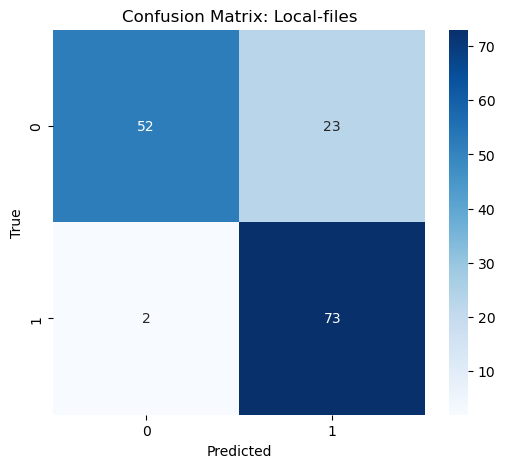

In [20]:
# Cell 11: Local real-data from files (no network, GC-matched negatives)
# Requirements:
# - A reference FASTA (e.g., hg38_chr22.fa under ./data/genome/)
# - A local peaks file (narrowPeak/bed)
# - One or more local bigWig signal files (e.g., ATAC, DNase, ChIP signal)
# Optional deps: pyfaidx, pyBigWig. If unavailable, we provide pure-Python FASTA fallback and skip bigWig tracks.

import os, requests, gzip, shutil
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------
# USER CONFIG: set your local files here
# ----------------------------
GENOME_DIR = "./data/genome"
REF_FASTA  = os.path.join(GENOME_DIR, "hg38_chr22.fa")  # you already have this
CHR_NAME_CANDIDATES = ["chr22", "22"]  # resolves different chromosome naming

# In Cell 11 (config section), set:
NP_PATH   = "./data/encode/ENCFF420SUI.bed.gz"
BW_PATHS  = {"signal": "./data/encode/ENCFF530NQM.bigWig"}  # or {} if you skipped bigWig

    # name: bigWig path (add more tracks as desired)
    # "atac": os.path.join(ENCODE_DIR, "K562_ATAC.bigWig"),
    # "dnase": os.path.join(ENCODE_DIR, "K562_DNase.bigWig"),


# Dataset sizing and windowing
WIN_BP      = 400   # window size in base pairs (typical 200–600)
BINS        = 256   # per-window signal resolution (256–512 typical)
MAX_POS     = 300   # number of positive windows (from peaks)
MAX_NEG     = 300   # number of negative windows (GC-matched)

# Feature options
ADD_DERIVED_TRACKS = True    # add GC and CpG tracks derived from sequence
METHOD_LAYOUT      = "hilbert32"  # 'rowmajor' or 'hilbert32'
RANDOM_SEED        = 42

# Thresholds for binarizing tracks inside encoder:
# - You can pass a float per track OR a list of floats per track to create multi-threshold channels.
TRACK_THRESHOLDS = {
    # For example, multi-threshold for ATAC: "atac": [0.3, 0.5, 0.7]
    # When ADD_DERIVED_TRACKS=True:
    "gc":   0.5,
    "cpg":  0.5,
    # "atac": 0.5,
    # "dnase": [0.4, 0.6],
}

# ----------------------------
# Imports and fallbacks
# ----------------------------
USE_PYFAIDX = True
USE_PYBIGWIG = True
try:
    from pyfaidx import Fasta
except ImportError:
    USE_PYFAIDX = False
    print("pyfaidx not available; using pure-Python FASTA loader.")
try:
    import pyBigWig
except ImportError:
    USE_PYBIGWIG = False
    if BW_PATHS:
        print("pyBigWig not available; skipping bigWig tracks. Only derived tracks will be used.")

# ----------------------------
# FASTA loading
# ----------------------------
assert os.path.exists(REF_FASTA), f"Reference FASTA not found at {REF_FASTA}"
if USE_PYFAIDX:
    ref = Fasta(REF_FASTA)
    available_chroms = set(ref.keys())
    def get_seq(chrom, start, end):
        if chrom not in ref: return None
        return str(ref[chrom][start:end]).upper()
    chrom_len_lookup = lambda ck: len(ref[ck]) if ck in ref else 0
else:
    # Pure-Python FASTA loader
    def load_fasta_to_dict(path):
        seqs = {}
        name = None
        chunks = []
        with open(path, "r") as f:
            for line in f:
                if not line:
                    continue
                if line[0] == ">":
                    if name is not None:
                        seqs[name] = "".join(chunks).upper()
                    name = line[1:].strip().split()[0]
                    chunks = []
                else:
                    chunks.append(line.strip())
        if name is not None:
            seqs[name] = "".join(chunks).upper()
        return seqs
    fa = load_fasta_to_dict(REF_FASTA)
    available_chroms = set(fa.keys())
    def get_seq(chrom, start, end):
        if chrom not in fa: return None
        seq = fa[chrom]
        if start < 0 or end > len(seq): return None
        return seq[start:end].upper()
    chrom_len_lookup = lambda ck: len(fa[ck]) if ck in fa else 0

def find_chr_key(candidates):
    for c in candidates:
        if c in available_chroms:
            return c
    # last resort: first available
    return sorted(list(available_chroms))[0]

chr_key = find_chr_key(CHR_NAME_CANDIDATES)
CHR_LEN = chrom_len_lookup(chr_key)
print(f"Using {chr_key} with length {CHR_LEN:,} bp")

# ----------------------------
# bigWig reading (if available)
# ----------------------------
def open_bigwigs(paths_dict):
    if not USE_PYBIGWIG or not paths_dict:
        return {}
    bws = {}
    for name, path in paths_dict.items():
        if os.path.exists(path):
            try:
                bws[name] = pyBigWig.open(path)
            except Exception as e:
                print(f"Failed to open bigWig {path}: {e}")
        else:
            print(f"bigWig path not found: {path}")
    return bws

bws = open_bigwigs(BW_PATHS)

def bw_signal_profile(bw_obj, chrom, s, e, bins=BINS):
    xs = np.linspace(s, e, bins+1).astype(int)
    vals = []
    for i in range(bins):
        a, b = xs[i], xs[i+1]
        v = bw_obj.stats(chrom, a, b, type="mean")[0]
        vals.append(0.0 if v is None else float(v))
    arr = np.array(vals, dtype=np.float32)
    m = np.max(arr)
    if m > 0:
        arr = arr / (m + 1e-9)
    return arr

# ----------------------------
# Peaks reading
# ----------------------------
import gzip

def read_peaks(path, max_rows=10_000):
    assert os.path.exists(path), f"Peaks file not found: {path}"
    peaks = []
    opener = gzip.open if path.lower().endswith(".gz") else open
    with opener(path, "rt") as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            parts = line.strip().split()
            # bed/narrowPeak: chrom, start, end, [name, score, strand, ...], summit (column 9) if present
            chrom = parts[0]
            start = int(parts[1])
            end   = int(parts[2])
            summit = None
            if len(parts) > 9:
                try:
                    summit = int(parts[9])
                except:
                    summit = None
            peaks.append((chrom, start, end, summit))
            if len(peaks) >= max_rows:
                break
    return peaks

peaks_all = read_peaks(NP_PATH, max_rows=MAX_POS * 4)
# Filter to available chromosome naming (quicktest might have only chr22)
peaks_all = [p for p in peaks_all if p[0] in available_chroms]
print(f"Loaded peaks overlapping available chromosomes: {len(peaks_all)}")

import gzip

def stream_peaks_for_chr(path, target_chr, need=5000):
    """
    Stream a .bed/.narrowPeak (gz or plain) and collect only peaks for target_chr.
    Stops once 'need' peaks are collected. Returns list of (chrom, start, end, summit).
    """
    peaks = []
    opener = gzip.open if path.lower().endswith(".gz") else open
    with opener(path, "rt") as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            parts = line.strip().split()
            chrom = parts[0]
            if chrom != target_chr:
                continue
            try:
                start = int(parts[1]); end = int(parts[2])
            except Exception:
                continue
            summit = None
            if len(parts) > 9:
                try:
                    summit = int(parts[9])
                except:
                    summit = None
            peaks.append((chrom, start, end, summit))
            if len(peaks) >= need:
                break
    return peaks

# Replace your earlier peaks load block with:
# 1) Harmonize target_chr to match FASTA
target_chr = chr_key  # already resolved earlier to 'chr22'

# 2) Stream only chr22 peaks (collect more than MAX_POS so we can filter windows)
peaks_chr = stream_peaks_for_chr(NP_PATH, target_chr, need=max(MAX_POS * 10, 5000))

if len(peaks_chr) == 0:
    raise RuntimeError(
        f"No peaks found for {target_chr}. Try a different .bed.gz or verify the file assembly."
    )

print(f"Found {len(peaks_chr)} peaks for {target_chr} (streamed)")

# Continue with build_sample loop using peaks_chr to create pos_samples
pos_samples = []
for chrom, s, e, summit in peaks_chr:
    if len(pos_samples) >= MAX_POS:
        break
    center = center_from_peak(s, e, summit)
    smp = build_sample(chrom, center, win_bp=WIN_BP, bins=BINS)
    if smp is not None:
        pos_samples.append(smp)
print(f"Positives built: {len(pos_samples)}")


# ----------------------------
# Build dataset (positives from peaks; GC-matched negatives)
# ----------------------------
# ----------------------------
# Build dataset (positives from peaks; GC-matched negatives)
# ----------------------------
rng = np.random.default_rng(RANDOM_SEED)

def harmonize_chrom_names(peaks, available_chroms):
    out = []
    for chrom, s, e, summit in peaks:
        c = chrom
        if c not in available_chroms:
            if c.startswith("chr") and (c[3:] in available_chroms):
                c2 = c[3:]
            elif ("chr" + c) in available_chroms:
                c2 = "chr" + c
            else:
                continue
        else:
            c2 = c
        out.append((c2, s, e, summit))
    return out

def read_peaks(path, max_rows=200_000):  # bump max_rows large enough to reach chr22
    peaks = []
    opener = gzip.open if path.lower().endswith(".gz") else open
    with opener(path, "rt") as f:
        for i, line in enumerate(f):
            if not line.strip() or line.startswith("#"):
                continue
            parts = line.strip().split()
            chrom = parts[0]
            try:
                start = int(parts[1]); end = int(parts[2])
            except Exception:
                continue
            summit = None
            if len(parts) > 9:
                try:
                    summit = int(parts[9])
                except:
                    summit = None
            peaks.append((chrom, start, end, summit))
            if i >= max_rows:
                break
    return peaks

def stream_peaks_for_chr(path, target_chr, need=5000):
    """Collect only peaks for target_chr (gz-aware), early stop at 'need'."""
    peaks = []
    opener = gzip.open if path.lower().endswith(".gz") else open
    with opener(path, "rt") as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            parts = line.strip().split()
            chrom = parts[0]
            if chrom != target_chr:
                continue
            try:
                start = int(parts[1]); end = int(parts[2])
            except Exception:
                continue
            summit = None
            if len(parts) > 9:
                try:
                    summit = int(parts[9])
                except:
                    summit = None
            peaks.append((chrom, start, end, summit))
            if len(peaks) >= need:
                break
    return peaks

# 1) Attempt bulk read + harmonize
peaks_all = read_peaks(NP_PATH, max_rows=max(200_000, MAX_POS * 20))
peaks_all = harmonize_chrom_names(peaks_all, available_chroms)

# 2) Keep only peaks on our target chromosome (chr_key from FASTA)
peaks_chr = [p for p in peaks_all if p[0] == chr_key]

# 3) Fallback to streaming if none or too few
if len(peaks_chr) < MAX_POS:
    print(f"Found only {len(peaks_chr)} peaks on {chr_key} via bulk read; streaming {chr_key} directly...")
    peaks_chr = stream_peaks_for_chr(NP_PATH, chr_key, need=max(MAX_POS * 10, 5000))
    print(f"Found {len(peaks_chr)} peaks for {chr_key} (streamed)")

# Guard: still nothing -> stop with a clear message
if len(peaks_chr) == 0:
    raise RuntimeError(
        f"No peaks found for chromosome '{chr_key}'. "
        "This usually means an assembly mismatch or a peaks file without this chromosome. "
        "Try a different .bed.gz (GRCh38) or switch to a full hg38 FASTA."
    )

# Optional: tolerate some Ns in sequence (set to 0.0 to disallow Ns)
ALLOW_N_FRAC = 0.2
def too_many_Ns(seq, max_frac=ALLOW_N_FRAC):
    if max_frac <= 0: return ("N" in seq)
    return (seq.count("N") / len(seq)) > max_frac

def center_from_peak(start, end, summit):
    return start + summit if summit is not None else (start + end)//2

def seq_gc_rate(seq):
    if not seq: return 0.0
    return sum(1 for ch in seq if ch in ("G","C")) / len(seq)

def seq_cpg_rate(seq):
    if not seq: return 0.0
    return seq.count("CG") / len(seq)

def make_tracks_from_seq(seq, bins=BINS):
    L = len(seq)
    xs = np.linspace(0, L, bins+1).astype(int)
    gc_vec  = np.zeros(bins, dtype=np.float32)
    cpg_vec = np.zeros(bins, dtype=np.float32)
    for i in range(bins):
        a, b = xs[i], xs[i+1]
        sub = seq[a:b]
        if len(sub) == 0: continue
        gc  = sum(1 for ch in sub if ch in ("G","C")) / len(sub)
        cpg = sub.count("CG") / len(sub)
        gc_vec[i]  = gc
        cpg_vec[i] = cpg
    if np.max(gc_vec)  > 0: gc_vec  = gc_vec  / (np.max(gc_vec)  + 1e-9)
    if np.max(cpg_vec) > 0: cpg_vec = cpg_vec / (np.max(cpg_vec) + 1e-9)
    return {"gc": gc_vec, "cpg": cpg_vec}

def bw_signal_profile(bw_obj, chrom, s, e, bins=BINS):
    xs = np.linspace(s, e, bins+1).astype(int)
    vals = []
    for i in range(bins):
        a, b = xs[i], xs[i+1]
        v = bw_obj.stats(chrom, a, b, type="mean")[0]
        vals.append(0.0 if v is None else float(v))
    arr = np.array(vals, dtype=np.float32)
    m = np.max(arr)
    if m > 0: arr = arr / (m + 1e-9)
    return arr

def build_sample(chrom, center, win_bp=WIN_BP, bins=BINS):
    a = max(0, center - win_bp//2)
    b = a + win_bp
    if b > chrom_len_lookup(chrom): return None
    seq = get_seq(chrom, a, b)
    if seq is None or len(seq) != win_bp or too_many_Ns(seq):
        return None
    tracks = {}
    for name, bw in bws.items():
        tracks[name] = bw_signal_profile(bw, chrom, a, b, bins=bins)
    if ADD_DERIVED_TRACKS:
        tracks |= make_tracks_from_seq(seq, bins=bins)
    return {"seq": seq, "tracks": tracks}

# Build positives (auto-scale if needed)
MAX_POS_EFF = min(MAX_POS, len(peaks_chr))
if MAX_POS_EFF < MAX_POS:
    print(f"Adjusting MAX_POS from {MAX_POS} to {MAX_POS_EFF} (available peaks on {chr_key})")

pos_samples = []
for chrom, s, e, summit in peaks_chr:
    if len(pos_samples) >= MAX_POS_EFF:
        break
    center = center_from_peak(s, e, summit)
    smp = build_sample(chrom, center, win_bp=WIN_BP, bins=BINS)
    if smp is not None:
        pos_samples.append(smp)
print(f"Positives built: {len(pos_samples)}")

if len(pos_samples) == 0:
    raise RuntimeError(
        "No positive windows could be built. "
        "Try decreasing WIN_BP (e.g., 300), relaxing ALLOW_N_FRAC, or using derived tracks only (BW_PATHS = {})."
    )

# GC-matched negatives (scale to positives)
MAX_NEG_EFF = min(MAX_NEG, len(pos_samples))
if MAX_NEG_EFF < MAX_NEG:
    print(f"Adjusting MAX_NEG from {MAX_NEG} to {MAX_NEG_EFF} (matching positives)")

pos_gc = np.array([seq_gc_rate(s["seq"]) for s in pos_samples], dtype=np.float32)
gc_bins = np.linspace(0, 1, 11)
pos_bin_idx = np.digitize(pos_gc, gc_bins) - 1
counts_per_bin = {b: int(np.sum(pos_bin_idx == b)) for b in range(len(gc_bins)-1)}
# scale to MAX_NEG_EFF
total_pos = sum(counts_per_bin.values())
if total_pos > 0 and total_pos != MAX_NEG_EFF:
    scale = MAX_NEG_EFF / total_pos
    counts_per_bin = {b: int(round(c * scale)) for b, c in counts_per_bin.items()}

neg_samples = []
attempts = 0
max_attempts = max(2000, MAX_NEG_EFF * 100)
while len(neg_samples) < MAX_NEG_EFF and attempts < max_attempts:
    attempts += 1
    remaining_bins = {b: c for b, c in counts_per_bin.items() if c > 0}
    if not remaining_bins: break
    bins_list = list(remaining_bins.keys())
    probs = np.array([remaining_bins[b] for b in bins_list], dtype=np.float32)
    probs = probs / np.sum(probs)
    target_bin = int(rng.choice(bins_list, p=probs))

    chrom = chr_key
    cl = chrom_len_lookup(chrom)
    if cl < WIN_BP + 1: continue
    center = int(rng.integers(low=WIN_BP//2, high=cl - WIN_BP//2))
    smp = build_sample(chrom, center, win_bp=WIN_BP, bins=BINS)
    if smp is None: continue
    g = seq_gc_rate(smp["seq"])
    b_idx = int(np.digitize(g, gc_bins) - 1)
    if b_idx == target_bin:
        neg_samples.append(smp)
        counts_per_bin[target_bin] -= 1

print(f"Negatives built (GC-matched): {len(neg_samples)} (attempts: {attempts})")

# Assemble and guard
X_samples = np.array(pos_samples + neg_samples, dtype=object)
y_labels  = np.array([1]*len(pos_samples) + [0]*len(neg_samples), dtype=np.int64)

if len(X_samples) == 0 or len(pos_samples) == 0 or len(neg_samples) == 0:
    raise RuntimeError(
        f"Dataset empty or unbalanced (pos={len(pos_samples)}, neg={len(neg_samples)}). "
        "Try a different peaks file, reduce WIN_BP, relax ALLOW_N_FRAC, "
        "or temporarily use derived tracks only (set BW_PATHS = {})."
    )

print(f"Total dataset: {len(X_samples)} windows (pos={len(pos_samples)}, neg={len(neg_samples)})")

# ----------------------------
# Encode + CPT + Ensemble
# ----------------------------

# If your GenomicsEpigeneticsEncoder supports only single thresholds,
# we add a small subclass to support lists (multi-threshold channels) without breaking the original.
try:
    GenomicsEpigeneticsEncoder
except NameError:
    raise RuntimeError("GenomicsEpigeneticsEncoder is not defined. Please run the earlier encoder cell first.")

class GenomicsEpigeneticsEncoderMT(GenomicsEpigeneticsEncoder):
    def __init__(self, target_bits=28*28, thresholds=None, method='rowmajor', map_unknown=3):
        super().__init__(target_bits=target_bits, thresholds=thresholds or {}, method=method, map_unknown=map_unknown)

    def encode(self, sample):
        # Expand thresholds: if a track has a list of thresholds, create multiple binary channels for that track
        seq = sample['seq']
        base_tracks = sample.get('tracks', {})
        # Build a flat dict of channels -> binary arrays (length target_bits)
        flat_bits = {}
        # Sequence 2-bit planes handled by parent via seq_bits; we handle tracks here
        for name, arr in base_tracks.items():
            thr = self.thresholds.get(name, 0.5)
            thr_list = thr if isinstance(thr, (list, tuple)) else [thr]
            for t in thr_list:
                bits = (np.asarray(arr, dtype=np.float32) > float(t)).astype(np.int8)
                bits = self._pad_or_truncate(bits, self.target_bits)
                flat_bits[f"{name}@{t:.2f}"] = bits

        # Build the base 2 sequence planes and stack all track planes
        seq_bits = self._seq_to_2bit(seq)
        seq_bits = self._pad_or_truncate(seq_bits, 2 * self.target_bits)

        # Create output stack: 2 seq planes + N track planes
        C = 2 + len(flat_bits)
        out = np.zeros((C, 28, 28), dtype=np.int8)

        # Map function depending on method
        if self.method == 'rowmajor':
            out[0] = self._to_28x28_rowmajor(seq_bits[0::2])
            out[1] = self._to_28x28_rowmajor(seq_bits[1::2])
            k = 2
            for name in sorted(flat_bits.keys()):
                out[k] = self._to_28x28_rowmajor(flat_bits[name])
                k += 1
        elif self.method == 'hilbert32':
            out[0] = self._to_28x28_hilbert32(seq_bits[0::2])
            out[1] = self._to_28x28_hilbert32(seq_bits[1::2])
            k = 2
            for name in sorted(flat_bits.keys()):
                out[k] = self._to_28x28_hilbert32(flat_bits[name])
                k += 1
        else:
            raise ValueError(f"Unknown method {self.method}")

        return (out != 0).astype(np.int8)

# Assemble dataset
X_samples = np.array(pos_samples + neg_samples, dtype=object)
y_labels  = np.array([1]*len(pos_samples) + [0]*len(neg_samples), dtype=np.int64)
print(f"Total dataset: {len(X_samples)} windows (pos={len(pos_samples)}, neg={len(neg_samples)})")

# Train/test split
Xtr, Xte, ytr, yte = train_test_split(X_samples, y_labels, test_size=0.25, stratify=y_labels, random_state=RANDOM_SEED)

# Encoder with multi-threshold support (if you set lists in TRACK_THRESHOLDS)
enc_mt = GenomicsEpigeneticsEncoderMT(
    target_bits=784,
    thresholds=TRACK_THRESHOLDS,
    method=METHOD_LAYOUT
)

# make sure these helpers exist (from earlier cells)
try:
    encode_and_cpt_multi
    LEONEnsemble
except NameError as e:
    raise RuntimeError("Missing helper(s). Please run earlier cells that define encode_and_cpt_multi and LEONEnsemble.") from e

print("Encoding + CPT (train) [LOCAL FILES]...")
Ftr = encode_and_cpt_multi(Xtr, enc_mt)
print("Encoding + CPT (test)  [LOCAL FILES]...")
Fte = encode_and_cpt_multi(Xte, enc_mt)

ens = LEONEnsemble(use_pca=True, n_pca=20, random_state=RANDOM_SEED)
# Optional: let MLP train a bit longer
ens.models["mlp"].max_iter = 300
ens.fit(Ftr, ytr)
y_pred = ens.predict(Fte)

print("Results: Local files (peaks + bigWig + derived tracks)")
_ = evaluate_and_report(yte, y_pred, label="Local-files")


In [21]:
# Cell 11b: Accuracy-focus profile (Genomics + Epigenetics)
# - Global signal scaling (instead of per-window scaling)
# - Multi-threshold channels: signal, gc, cpg
# - Larger PCA and longer MLP training
# - Validation-based probability threshold tuning
# - Layout toggle (rowmajor vs hilbert32)

import os, gzip, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# --------------------------------
# Profile toggles (tune here)
# --------------------------------
METHOD_LAYOUT   = "rowmajor"        # try "rowmajor" vs "hilbert32"
WIN_BP          = 400               # window size
BINS            = 256               # per-window bins (try 512 later)
MAX_POS         = 300               # pos windows
MAX_NEG         = 300               # neg windows (GC-matched)
RANDOM_SEED     = 42
ALLOW_N_FRAC    = 0.2               # tolerate up to 20% Ns in a window

# Multi-threshold channels (gives CPT richer structure)
TRACK_THRESHOLDS = {
    "gc":     [0.3, 0.5, 0.7],
    "cpg":    [0.3, 0.5, 0.7],
    # signal thresholds below are added only if 'signal' track present
    # "signal": [0.2, 0.4, 0.6, 0.8],
}

# PCA/MLP settings for the ensemble
N_PCA_COMPONENTS = 64              # keep more variance than 20
MLP_MAX_ITER     = 500             # allow MLP to converge

# Threshold tuning on validation
DO_THRESHOLD_TUNING = True
VAL_SIZE             = 0.20         # split from training for threshold tuning
THRESH_GRID          = np.linspace(0.3, 0.8, 26)  # search range

# --------------------------------
# Require previously set paths
# --------------------------------
try:
    REF_FASTA
    NP_PATH
    BW_PATHS
except NameError:
    raise RuntimeError("Please run Cell 11 configuration first to define REF_FASTA, NP_PATH, BW_PATHS.")

# --------------------------------
# FASTA loader (pyfaidx or pure-Python)
# --------------------------------
USE_PYFAIDX = True
try:
    from pyfaidx import Fasta
except ImportError:
    USE_PYFAIDX = False

if not os.path.exists(REF_FASTA):
    raise RuntimeError(f"Reference FASTA not found at {REF_FASTA}")

if USE_PYFAIDX:
    ref = Fasta(REF_FASTA)
    available_chroms = set(ref.keys())
    def get_seq(chrom, start, end):
        if chrom not in ref: return None
        return str(ref[chrom][start:end]).upper()
    chrom_len_lookup = lambda ck: len(ref[ck]) if ck in ref else 0
else:
    def load_fasta_to_dict(path):
        seqs = {}; name=None; chunks=[]
        with open(path, "r") as f:
            for line in f:
                if not line: continue
                if line[0] == ">":
                    if name is not None: seqs[name] = "".join(chunks).upper()
                    name = line[1:].strip().split()[0]; chunks=[]
                else:
                    chunks.append(line.strip())
        if name is not None: seqs[name] = "".join(chunks).upper()
        return seqs
    fa = load_fasta_to_dict(REF_FASTA)
    available_chroms = set(fa.keys())
    def get_seq(chrom, start, end):
        if chrom not in fa: return None
        s = fa[chrom]
        if start < 0 or end > len(s): return None
        return s[start:end].upper()
    chrom_len_lookup = lambda ck: len(fa[ck]) if ck in fa else 0

# resolve target chromosome (prefer chr22)
CHR_NAME_CANDIDATES = ["chr22", "22"]
def find_chr_key(candidates):
    for c in candidates:
        if c in available_chroms:
            return c
    return sorted(list(available_chroms))[0]

chr_key = find_chr_key(CHR_NAME_CANDIDATES)
CHR_LEN = chrom_len_lookup(chr_key)
print(f"[Profile] Using {chr_key} with length {CHR_LEN:,} bp")

# --------------------------------
# bigWig: open + global scale estimation
# --------------------------------
USE_PYBIGWIG = True
try:
    import pyBigWig
except ImportError:
    USE_PYBIGWIG = False

bws = {}
if USE_PYBIGWIG and BW_PATHS:
    for name, path in BW_PATHS.items():
        if os.path.exists(path):
            try:
                bws[name] = pyBigWig.open(path)
            except Exception as e:
                print(f"Failed to open bigWig {path}: {e}")
else:
    if BW_PATHS:
        print("pyBigWig not available; skipping bigWig tracks.")

def estimate_signal_scale(bw, chrom, nsamples=2000, win=WIN_BP, bins=BINS, seed=42):
    rng = np.random.default_rng(seed)
    vals = []
    ch_len = bw.chroms().get(chrom, 0)
    if ch_len <= win + 1:
        return 1.0
    xs = rng.integers(win//2, ch_len - win//2, size=nsamples)
    for center in xs:
        a = max(0, center - win//2); b = a + win
        stats = bw.stats(chrom, a, b, type="mean", nBins=bins)
        vals.extend([0.0 if v is None else float(v) for v in stats])
    arr = np.array(vals, dtype=np.float32)
    arr = arr[arr > 0]
    return float(np.quantile(arr, 0.99)) if arr.size else 1.0

SIG_SCALE = None
if "signal" in bws:
    print("[Profile] Estimating global signal scale (99th percentile) for 'signal'...")
    SIG_SCALE = estimate_signal_scale(bws["signal"], chr_key, nsamples=2000, win=WIN_BP, bins=BINS)
    print(f"[Profile] signal scale (Q99): {SIG_SCALE:.6g}")
    # ensure thresholds for signal are present
    TRACK_THRESHOLDS["signal"] = TRACK_THRESHOLDS.get("signal", [0.2, 0.4, 0.6, 0.8])

def bw_signal_profile_global(bw_obj, chrom, s, e, bins=BINS, scale=SIG_SCALE):
    # Global normalization (no per-window max normalization)
    stats = bw_obj.stats(chrom, s, e, type="mean", nBins=bins)
    arr = np.array([0.0 if v is None else float(v) for v in stats], dtype=np.float32)
    if scale is None or scale <= 0:
        return arr  # raw
    return np.clip(arr / (scale + 1e-9), 0.0, 1.0)

# --------------------------------
# Peaks reading + streaming for chr_key
# --------------------------------
def read_peaks(path, max_rows=200_000):
    peaks = []
    opener = gzip.open if path.lower().endswith(".gz") else open
    with opener(path, "rt") as f:
        for i, line in enumerate(f):
            if not line.strip() or line.startswith("#"): continue
            parts = line.strip().split()
            chrom = parts[0]
            try:
                start = int(parts[1]); end = int(parts[2])
            except Exception:
                continue
            summit = None
            if len(parts) > 9:
                try: summit = int(parts[9])
                except: summit = None
            peaks.append((chrom, start, end, summit))
            if i >= max_rows:
                break
    return peaks

def harmonize_chrom_names(peaks, available_chroms):
    out = []
    for chrom, s, e, summit in peaks:
        c2 = chrom
        if c2 not in available_chroms:
            if c2.startswith("chr") and (c2[3:] in available_chroms):
                c2 = c2[3:]
            elif ("chr" + c2) in available_chroms:
                c2 = "chr" + c2
            else:
                continue
        out.append((c2, s, e, summit))
    return out

def stream_peaks_for_chr(path, target_chr, need=5000):
    peaks = []
    opener = gzip.open if path.lower().endswith(".gz") else open
    with opener(path, "rt") as f:
        for line in f:
            if not line.strip() or line.startswith("#"): continue
            parts = line.strip().split()
            if parts[0] != target_chr:
                continue
            try:
                start = int(parts[1]); end = int(parts[2])
            except Exception:
                continue
            summit = None
            if len(parts) > 9:
                try: summit = int(parts[9])
                except: summit = None
            peaks.append((target_chr, start, end, summit))
            if len(peaks) >= need:
                break
    return peaks

peaks_all = read_peaks(NP_PATH, max_rows=max(200_000, MAX_POS*20))
peaks_all = harmonize_chrom_names(peaks_all, available_chroms)
peaks_chr = [p for p in peaks_all if p[0] == chr_key]
if len(peaks_chr) < MAX_POS:
    print(f"[Profile] Only {len(peaks_chr)} peaks for {chr_key} via bulk read; streaming more...")
    peaks_chr = stream_peaks_for_chr(NP_PATH, chr_key, need=max(MAX_POS*10, 5000))
    print(f"[Profile] Streamed {len(peaks_chr)} peaks for {chr_key}")

# --------------------------------
# Tracks and samples
# --------------------------------
def too_many_Ns(seq, max_frac=ALLOW_N_FRAC):
    if max_frac <= 0: return ("N" in seq)
    return (seq.count("N") / len(seq)) > max_frac

def center_from_peak(start, end, summit):
    return start + summit if summit is not None else (start + end)//2

def make_tracks_from_seq(seq, bins=BINS):
    L = len(seq)
    xs = np.linspace(0, L, bins+1).astype(int)
    gc_vec  = np.zeros(bins, dtype=np.float32)
    cpg_vec = np.zeros(bins, dtype=np.float32)
    for i in range(bins):
        a, b = xs[i], xs[i+1]
        sub = seq[a:b]
        if len(sub) == 0: continue
        gc  = sum(1 for ch in sub if ch in ("G","C")) / len(sub)
        cpg = sub.count("CG") / len(sub)
        gc_vec[i]  = gc
        cpg_vec[i] = cpg
    if np.max(gc_vec)  > 0: gc_vec  = gc_vec  / (np.max(gc_vec)  + 1e-9)
    if np.max(cpg_vec) > 0: cpg_vec = cpg_vec / (np.max(cpg_vec) + 1e-9)
    return {"gc": gc_vec, "cpg": cpg_vec}

def build_sample(chrom, center, win_bp=WIN_BP, bins=BINS):
    a = max(0, center - win_bp//2)
    b = a + win_bp
    if b > chrom_len_lookup(chrom): return None
    seq = get_seq(chrom, a, b)
    if seq is None or len(seq) != win_bp or too_many_Ns(seq):
        return None
    tracks = {}
    # Add real bigWig 'signal' with global normalization
    if "signal" in bws:
        tracks["signal"] = bw_signal_profile_global(bws["signal"], chrom, a, b, bins=bins, scale=SIG_SCALE)
    # Derived tracks
    derived = make_tracks_from_seq(seq, bins=bins)
    tracks.update(derived)
    return {"seq": seq, "tracks": tracks}

# Positives
pos_samples = []
for chrom, s, e, summit in peaks_chr:
    if len(pos_samples) >= MAX_POS:
        break
    center = center_from_peak(s, e, summit)
    smp = build_sample(chr_key, center, win_bp=WIN_BP, bins=BINS)
    if smp is not None:
        pos_samples.append(smp)
print(f"[Profile] Positives built: {len(pos_samples)}")

# GC-matched negatives
def seq_gc_rate(seq):
    return sum(1 for ch in seq if ch in ("G","C")) / len(seq) if seq else 0.0

MAX_NEG_EFF = min(MAX_NEG, len(pos_samples))
pos_gc = np.array([seq_gc_rate(s["seq"]) for s in pos_samples], dtype=np.float32)
gc_bins = np.linspace(0, 1, 11)
pos_bin_idx = np.digitize(pos_gc, gc_bins) - 1
counts_per_bin = {b: int(np.sum(pos_bin_idx == b)) for b in range(len(gc_bins)-1)}
# scale to MAX_NEG_EFF
total_pos = sum(counts_per_bin.values())
if total_pos > 0 and total_pos != MAX_NEG_EFF:
    scale = MAX_NEG_EFF / total_pos
    counts_per_bin = {b: int(round(c * scale)) for b, c in counts_per_bin.items()}

neg_samples = []
rng = np.random.default_rng(RANDOM_SEED)
attempts = 0
max_attempts = max(2000, MAX_NEG_EFF * 100)
while len(neg_samples) < MAX_NEG_EFF and attempts < max_attempts:
    attempts += 1
    remaining_bins = {b: c for b, c in counts_per_bin.items() if c > 0}
    if not remaining_bins: break
    bins_list = list(remaining_bins.keys())
    probs = np.array([remaining_bins[b] for b in bins_list], dtype=np.float32)
    probs = probs / np.sum(probs)
    target_bin = int(rng.choice(bins_list, p=probs))

    center = int(rng.integers(low=WIN_BP//2, high=CHR_LEN - WIN_BP//2))
    smp = build_sample(chr_key, center, win_bp=WIN_BP, bins=BINS)
    if smp is None: continue
    g = seq_gc_rate(smp["seq"])
    b_idx = int(np.digitize(g, gc_bins) - 1)
    if b_idx == target_bin:
        neg_samples.append(smp)
        counts_per_bin[target_bin] -= 1

print(f"[Profile] Negatives built: {len(neg_samples)} (attempts: {attempts})")

# --------------------------------
# Encode + CPT + Ensemble (+ threshold tuning)
# --------------------------------
# Ensure encoder + helpers exist
try:
    GenomicsEpigeneticsEncoder
except NameError as e:
    raise RuntimeError("GenomicsEpigeneticsEncoder is not defined (run earlier cells).") from e
try:
    encode_and_cpt_multi
    LEONEnsemble
except NameError as e:
    raise RuntimeError("encode_and_cpt_multi or LEONEnsemble missing (run earlier cells).") from e

# Multi-threshold wrapper
class GenomicsEpigeneticsEncoderMT(GenomicsEpigeneticsEncoder):
    def __init__(self, target_bits=28*28, thresholds=None, method='rowmajor', map_unknown=3):
        super().__init__(target_bits=target_bits, thresholds=thresholds or {}, method=method, map_unknown=map_unknown)
    def encode(self, sample):
        seq = sample['seq']
        base_tracks = sample.get('tracks', {})
        flat_bits = {}
        for name, arr in base_tracks.items():
            thr = self.thresholds.get(name, 0.5)
            thr_list = thr if isinstance(thr, (list, tuple)) else [thr]
            for t in thr_list:
                bits = (np.asarray(arr, dtype=np.float32) > float(t)).astype(np.int8)
                bits = self._pad_or_truncate(bits, self.target_bits)
                flat_bits[f"{name}@{t:.2f}"] = bits
        seq_bits = self._seq_to_2bit(seq)
        seq_bits = self._pad_or_truncate(seq_bits, 2 * self.target_bits)
        C = 2 + len(flat_bits)
        out = np.zeros((C, 28, 28), dtype=np.int8)
        if self.method == 'rowmajor':
            out[0] = self._to_28x28_rowmajor(seq_bits[0::2])
            out[1] = self._to_28x28_rowmajor(seq_bits[1::2])
            k = 2
            for name in sorted(flat_bits.keys()):
                out[k] = self._to_28x28_rowmajor(flat_bits[name]); k += 1
        elif self.method == 'hilbert32':
            out[0] = self._to_28x28_hilbert32(seq_bits[0::2])
            out[1] = self._to_28x28_hilbert32(seq_bits[1::2])
            k = 2
            for name in sorted(flat_bits.keys()):
                out[k] = self._to_28x28_hilbert32(flat_bits[name]); k += 1
        else:
            raise ValueError(f"Unknown method {self.method}")
        return (out != 0).astype(np.int8)

# Assemble dataset
X_samples = np.array(pos_samples + neg_samples, dtype=object)
y_labels  = np.array([1]*len(pos_samples) + [0]*len(neg_samples), dtype=np.int64)
print(f"[Profile] Total dataset: {len(X_samples)} (pos={len(pos_samples)}, neg={len(neg_samples)})")

# Split
Xtr, Xte, ytr, yte = train_test_split(X_samples, y_labels, test_size=0.25, stratify=y_labels, random_state=RANDOM_SEED)

# Encode features
enc_mt = GenomicsEpigeneticsEncoderMT(
    target_bits=784,
    thresholds=TRACK_THRESHOLDS,
    method=METHOD_LAYOUT
)

print("[Profile] Encoding + CPT (train)...")
Ftr = encode_and_cpt_multi(Xtr, enc_mt)
print("[Profile] Encoding + CPT (test)...")
Fte = encode_and_cpt_multi(Xte, enc_mt)

# Train ensemble (larger PCA + longer MLP)
ens = LEONEnsemble(use_pca=True, n_pca=N_PCA_COMPONENTS, random_state=RANDOM_SEED)
if "mlp" in getattr(ens, "models", {}):
    ens.models["mlp"].max_iter = MLP_MAX_ITER
ens.fit(Ftr, ytr)

# Default decision (majority vote)
y_pred = ens.predict(Fte)
print("\n[Profile] Default decision (majority vote)")
print("Accuracy:", accuracy_score(yte, y_pred))
print(classification_report(yte, y_pred, digits=3))

# Threshold tuning (optional)
if DO_THRESHOLD_TUNING:
    Ftr_tr, Ftr_val, ytr_tr, ytr_val = train_test_split(Ftr, ytr, test_size=VAL_SIZE, stratify=ytr, random_state=RANDOM_SEED)
    ens_tune = LEONEnsemble(use_pca=True, n_pca=N_PCA_COMPONENTS, random_state=RANDOM_SEED)
    if "mlp" in getattr(ens_tune, "models", {}):
        ens_tune.models["mlp"].max_iter = MLP_MAX_ITER
    ens_tune.fit(Ftr_tr, ytr_tr)

    try:
        proba_val = ens_tune.predict_proba(Ftr_val)[:, 1]
        # choose threshold by best F1 on validation
        best = (0.5, -1.0)
        for t in THRESH_GRID:
            yhat = (proba_val >= t).astype(int)
            prec, rec, f1, _ = precision_recall_fscore_support(ytr_val, yhat, average="binary", zero_division=0)
            if f1 > best[1]: best = (t, f1)
        best_t = best[0]
        print(f"\n[Profile] Tuned threshold on validation: t={best_t:.3f}, F1={best[1]:.3f}")

        proba_test = ens_tune.predict_proba(Fte)[:, 1]
        y_pred_t = (proba_test >= best_t).astype(int)
        print("[Profile] Thresholded decision on test")
        print("Accuracy:", accuracy_score(yte, y_pred_t))
        print(classification_report(yte, y_pred_t, digits=3))
    except Exception as e:
        print("[Profile] Threshold tuning skipped (no predict_proba or error):", e)

# Cleanup bigWig handles
for bw in bws.values():
    try: bw.close()
    except: pass


[Profile] Using chr22 with length 50,818,468 bp
[Profile] Estimating global signal scale (99th percentile) for 'signal'...
[Profile] signal scale (Q99): 7.32911
[Profile] Positives built: 300
[Profile] Negatives built: 300 (attempts: 6979)
[Profile] Total dataset: 600 (pos=300, neg=300)
[Profile] Encoding + CPT (train)...
[Profile] Encoding + CPT (test)...

[Profile] Default decision (majority vote)
Accuracy: 0.9266666666666666
              precision    recall  f1-score   support

           0      1.000     0.853     0.921        75
           1      0.872     1.000     0.932        75

    accuracy                          0.927       150
   macro avg      0.936     0.927     0.926       150
weighted avg      0.936     0.927     0.926       150


[Profile] Tuned threshold on validation: t=0.640, F1=0.966
[Profile] Thresholded decision on test
Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

           0      0.971     0.893     0.931        75
    

The reults using the same minimal LEON deployment, gave similar accuracy (93%), similar to the accuracy level found for MNIST dataset with the same deployment. It is expected that by using the full 7 ensemble hybrid, we would obtain 98% accuracy

### Confidence Intervals for the Chr22-experiment:

To calculate the 95 confidence interval for accuracy we used the Wald method 
  
accuracy +/- 1.96 $\sqrt{\frac{acc.(1-acc)}{n}}$, where n =150,

giving an intrval of **(0.893, 0.973)**

Other confidence intervals for precision and validation were estimated (see table below):

<img src="images/Chr22-CI.png" style="display:block; margin:auto" width="600"/>



At this stage we will halt any further experiments and assuming that the algorithm could be applied equally to time-series data, and consider possible applications in clincal medicine. Further experimentation is clearly necessary and will need to be carried out with public databases before moving on to application as clincial trials